# Прогнозирование спроса
**Краткое описание**:
<br>Необходимо создать алгоритм прогноза спроса на 14 дней для товаров собственного производства.
<br>Гранулярность ТК-SKU-День.

**Задача**:
<br>Построить модель прогноза спроса на основе мастер данных и данных продаж с учетом разных признаков.

**Метрика качества - `WAPE`**:

```Python
def wape(y_true: np.array, y_pred: np.array):
    return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))
```

**Описание данных**

- sales_df_train.csv –данные по продажам за скользящий год для обучения.
    - st_id – захэшированное id магазина;
    - pr_sku_id – захэшированное id товара;
    - date – дата;
    - pr_sales_type_id – флаг наличия промо;
    - pr_sales_in_units – число проданных товаров всего (промо и без);
    - pr_promo_sales_in_units – число проданных товаров с признаком промо;
    - pr_sales_in_rub – продажи в РУБ всего (промо и без);
    - pr_promo_sales_in_rub – продажи с признаком промо в РУБ;
- pr_df.csv – данные по товарной иерархии.
От большего к меньшему pr_group_id - pr_cat_id - pr_subcat_id - pr_sku_id.
    - pr_group_id – захэшированная группа товара;
    - pr_cat_id – захэшированная категория товара;
    - pr_subcat_id – захэшированная подкатегория товара;
    - pr_sku_id – захэшированное id товара;
    - pr_uom_id (маркер, обозначающий продаётся товар на вес или в ШТ).
- pr_st.csv – данные по магазинам.
    - st_id – захэшированное id магазина;
    - st_city_id – захэшированное id города;
    - st_division_code id – захэшированное id дивизиона;
    - st_type_format_id – id формата магазина;
    - st_type_loc_id – id тип локации/окружения магазина;
    - st_type_size_id – id типа размера магазина;
    - st_is_active – флаг активного магазина на данный момент.
- sales_submission.csv – пример файла с результатом работы модели прогноза спроса.
<br>Необходимо подготовить файл в таком же формате, заполнив колонку target предсказаниями (по
умолчанию колонка заполнена нулями).
    - st_id – захэшированное id магазина;
    - pr_sku_id – захэшированное id товара;
    - date – дата (день);
    - target – спрос в ШТ.

## Setting up the work environment

In [17]:
# !pip install pandas
# !pip install seaborn
# !pip install psycopg2-binary
# !pip install python-dotenv
# !pip install phik
# !pip install statsmodels
# !pip install scikit-learn
# !pip install category_encoders
# !pip install mlflow
# !pip install lightgbm

!pip freeze > requirements.txt

In [1]:
import os
import math
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from statsmodels.tsa.stattools import adfuller
from phik.report import plot_correlation_matrix
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose

# os.environ['VIRTUAL_ENV']

Объявление глобальных переменных

In [2]:
HOLIDAYS_PATH = 'data/holidays_covid_calendar.csv'
SALES_PATH = 'data/sales_df_train.csv'
PRODUCTS_PATH = 'data/pr_df.csv'
SHOPS_PATH = 'data/st_df.csv'

ASSETS_DIR = 'assets'
RANDOM_STATE = 42
DAYS_PRED = 14
random.seed(RANDOM_STATE)
EXPERIMENT_NAME = 'lenta_demand_forecast'

load_dotenv()
sns.set_style("white")
sns.set_theme(style="whitegrid")
pd.options.display.max_rows = 20
pd.options.display.max_columns = 30

connection = {"sslmode": "require",
              "target_session_attrs": "read-write"}
postgres_credentials = {"host": os.getenv("DB_HOST"),
                        "port": os.getenv("DB_PORT"),
                        "dbname": os.getenv("DB_NAME"),
                        "user": os.getenv("DB_USERNAME"),
                        "password": os.getenv("DB_PASSWORD")}
TRACKING_SERVER_PORT = os.getenv("TRACKING_SERVER_PORT")
TRACKING_SERVER_HOST = os.getenv("TRACKING_SERVER_HOST")

Импорт класса для проведения исследования

In [3]:
%load_ext autoreload
%autoreload 2

from regression_research_class import DatasetExplorer

## EDA

### sales_df_train

In [7]:
sales_explorer = DatasetExplorer(SALES_PATH)

Общая информация по набору данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   st_id                    883015 non-null  object 
 1   pr_sku_id                883015 non-null  object 
 2   date                     883015 non-null  object 
 3   pr_sales_type_id         883015 non-null  int64  
 4   pr_sales_in_units        883015 non-null  float64
 5   pr_promo_sales_in_units  883015 non-null  float64
 6   pr_sales_in_rub          883015 non-null  float64
 7   pr_promo_sales_in_rub    883015 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 53.9+ MB

Первые пять строк набора данных:


,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0



Количество полных дубликатов строк:


0


Количество пропущенных значений:


st_id                      0
pr_sku_id                  0
date                       0
pr_sales_type_id           0
pr_sales_in_units          0
pr_promo_sales_in_units    0
pr_sales_in_rub            0
pr_promo_sales_in_rub      0
dtype: int64


Процент пропущенных значений в признаках:
Количество уникальных значений в столбце 'st_id': 12
Соотношение уникальных значений и общего количества записей в столбце 'st_id': 0.0000
Количество уникальных значений в столбце 'pr_sku_id': 1991
Соотношение уникальных значений и общего количества записей в столбце 'pr_sku_id': 0.0023
Количество уникальных значений в столбце 'pr_sales_type_id': 2
Соотношение уникальных значений и общего количества записей в столбце 'pr_sales_type_id': 0.0000

Описательные статистики целевой переменной:


count    883015.000000
mean          5.037956
std          13.402984
min         -39.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        2348.000000
Name: pr_sales_in_units, dtype: float64

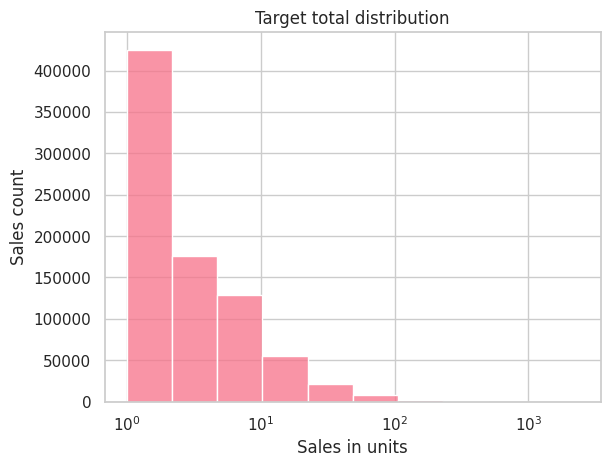

In [6]:
sales_df_train = sales_explorer.explore_dataset(target='pr_sales_in_units', assets_dir=None)

#### Выводы и наблюдения:
- для проведения дальнейшего исследования необходимо преобразование дат;
- пропусков в данных не обнаружено;
- полных дубликатов строк не обнаружено;
- количество уникальных товаров - 1991;
- в целевой переменной имеются отрицательные значения,
  <br>вероятно, это возвраты товаров.

### products_df

In [7]:
products_explorer = DatasetExplorer(PRODUCTS_PATH)

In [9]:
products_df = products_explorer.explore_dataset(target=None, assets_dir=None)

Общая информация по набору данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pr_sku_id     2050 non-null   object
 1   pr_group_id   2050 non-null   object
 2   pr_cat_id     2050 non-null   object
 3   pr_subcat_id  2050 non-null   object
 4   pr_uom_id     2050 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 80.2+ KB

Первые пять строк набора данных:


,pr_sku_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
0,fd064933250b0bfe4f926b867b0a5ec8,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,17
1,71c9661741caf40a92a32d1cc8206c04,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17
2,00b72c2f01a1512cbb1d3f33319bac93,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,d407a3ebb4ab9b0d68b224486f8b8dad,17
3,9bc40cd2fe4f188f402bb41548c5e15c,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,17
4,3a74a370c8eb032acb11ad9119242b8f,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17



Количество полных дубликатов строк:


0


Количество пропущенных значений:


pr_sku_id       0
pr_group_id     0
pr_cat_id       0
pr_subcat_id    0
pr_uom_id       0
dtype: int64


Процент пропущенных значений в признаках:
Количество уникальных значений в столбце 'pr_sku_id': 2050
Соотношение уникальных значений и общего количества записей в столбце 'pr_sku_id': 1.0000
Количество уникальных значений в столбце 'pr_group_id': 9
Соотношение уникальных значений и общего количества записей в столбце 'pr_group_id': 0.0044
Количество уникальных значений в столбце 'pr_cat_id': 43
Соотношение уникальных значений и общего количества записей в столбце 'pr_cat_id': 0.0210
Количество уникальных значений в столбце 'pr_subcat_id': 170
Соотношение уникальных значений и общего количества записей в столбце 'pr_subcat_id': 0.0829
Количество уникальных значений в столбце 'pr_uom_id': 2
Соотношение уникальных значений и общего количества записей в столбце 'pr_uom_id': 0.0010


#### Выводы и наблюдения:
- полных дубликатов строк не обнаружено;
- пропусков в данных не обнаружено.

### shops_df

In [8]:
shops_explorer = DatasetExplorer(SHOPS_PATH)

In [10]:
shops_df = shops_explorer.explore_dataset(target=None, assets_dir=None)

Общая информация по набору данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   st_id              12 non-null     object
 1   st_city_id         12 non-null     object
 2   st_division_code   12 non-null     object
 3   st_type_format_id  12 non-null     int64 
 4   st_type_loc_id     12 non-null     int64 
 5   st_type_size_id    12 non-null     int64 
 6   st_is_active       12 non-null     int64 
dtypes: int64(4), object(3)
memory usage: 800.0+ bytes

Первые пять строк набора данных:


,st_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
0,1aa057313c28fa4a40c5bc084b11d276,1587965fb4d4b5afe8428a4a024feb0d,81b4dd343f5880df806d4c5d4a846c64,4,3,19,0
1,bd470ca955d9497bbcb808e59952fffc,955d864a62659945cc9434898e275deb,e26072c92d8fe0738df44d571d5f5e8b,4,3,19,1
2,6364d3f0f495b6ab9dcf8d3b5c6e0b01,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
3,1ecfb463472ec9115b10c292ef8bc986,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,2,1,28,1
4,16a5cdae362b8d27a1d8f8c7b78b4330,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1



Количество полных дубликатов строк:


0


Количество пропущенных значений:


st_id                0
st_city_id           0
st_division_code     0
st_type_format_id    0
st_type_loc_id       0
st_type_size_id      0
st_is_active         0
dtype: int64


Процент пропущенных значений в признаках:
Количество уникальных значений в столбце 'st_id': 12
Соотношение уникальных значений и общего количества записей в столбце 'st_id': 1.0000
Количество уникальных значений в столбце 'st_city_id': 7
Соотношение уникальных значений и общего количества записей в столбце 'st_city_id': 0.5833
Количество уникальных значений в столбце 'st_type_format_id': 3
Соотношение уникальных значений и общего количества записей в столбце 'st_type_format_id': 0.2500
Количество уникальных значений в столбце 'st_type_loc_id': 3
Соотношение уникальных значений и общего количества записей в столбце 'st_type_loc_id': 0.2500
Количество уникальных значений в столбце 'st_type_size_id': 6
Соотношение уникальных значений и общего количества записей в столбце 'st_type_size_id': 0.5000


#### Выводы и наблюдения:
- полных дубликатов строк не обнаружено;
- пропущенных значений в данных не обнаружено;
- количество уникальных магазинов - 12

### holiday_df

In [11]:
holiday_explorer = DatasetExplorer(HOLIDAYS_PATH)

In [12]:
holiday_df = holiday_explorer.explore_dataset(target=None, assets_dir=None)

Общая информация по набору данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   year     3653 non-null   int64 
 1   day      3653 non-null   int64 
 2   weekday  3653 non-null   int64 
 3   date     3653 non-null   object
 4   calday   3653 non-null   int64 
 5   holiday  3653 non-null   int64 
 6   covid    3653 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 199.9+ KB

Первые пять строк набора данных:


,year,day,weekday,date,calday,holiday,covid
0,2015,1,4,01.01.2015,20150101,1,0
1,2015,2,5,02.01.2015,20150102,1,0
2,2015,3,6,03.01.2015,20150103,1,0
3,2015,4,7,04.01.2015,20150104,1,0
4,2015,5,1,05.01.2015,20150105,1,0



Количество полных дубликатов строк:


0


Количество пропущенных значений:


year       0
day        0
weekday    0
date       0
calday     0
holiday    0
covid      0
dtype: int64


Процент пропущенных значений в признаках:
Количество уникальных значений в столбце 'holiday': 2
Соотношение уникальных значений и общего количества записей в столбце 'holiday': 0.0005
Количество уникальных значений в столбце 'covid': 2
Соотношение уникальных значений и общего количества записей в столбце 'covid': 0.0005


#### Выводы и наблюдения:
- пропусков не обнаружено;
- повторов строк нет;
- в наборе данных имеются метка принадлежности выходного к covid-19;
- для дальнейшей работы с этим датафреймом необходимо преобразование дат.

### merge_df

In [26]:
holiday_df['date'] = pd.to_datetime(holiday_df['date'], format='%d.%m.%Y')
sales_df_train['date'] = pd.to_datetime(sales_df_train['date'], format='%Y-%m-%d')
main_df = (
    sales_df_train
    .merge(holiday_df[['date', 'holiday', 'covid']], on='date', how='left')
    .merge(shops_df, on='st_id', how='left')
    .merge(products_df, on='pr_sku_id', how='left')
)
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   st_id                    883015 non-null  object        
 1   pr_sku_id                883015 non-null  object        
 2   date                     883015 non-null  datetime64[ns]
 3   pr_sales_type_id         883015 non-null  int64         
 4   pr_sales_in_units        883015 non-null  float64       
 5   pr_promo_sales_in_units  883015 non-null  float64       
 6   pr_sales_in_rub          883015 non-null  float64       
 7   pr_promo_sales_in_rub    883015 non-null  float64       
 8   holiday                  883015 non-null  int64         
 9   covid                    883015 non-null  int64         
 10  st_city_id               883015 non-null  object        
 11  st_division_code         883015 non-null  object        
 12  st_type_format_i

In [27]:
print('Количество записей по активным и неактивным магазинам:')
main_df['st_is_active'].value_counts()

Количество записей по активным и неактивным магазинам:


st_is_active
1    882286
0       729
Name: count, dtype: int64

Вывод:
- количество записей по неактивным магазинам менее 1%,
  <br>принимаю решение данные записи удалить.

In [28]:
main_df = main_df[main_df['st_is_active'] == 1].reset_index(drop=True)

Количество отрицательных и нулевых значений целевой переменной:


66613

Доля отрицательных и нулевых значений целевой переменной в данных:


7.55

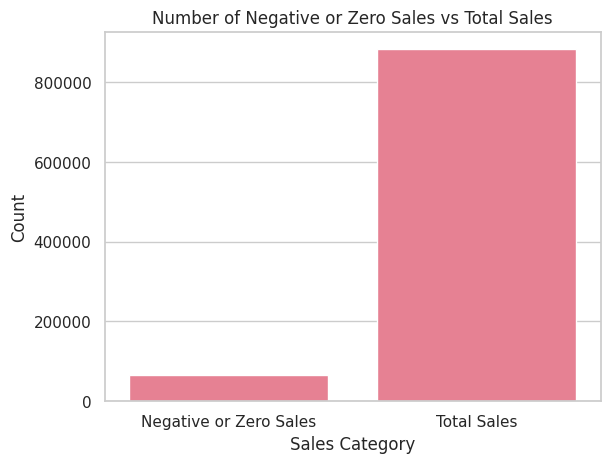

In [16]:
print('Количество отрицательных и нулевых значений целевой переменной:')
display(main_df[main_df['pr_sales_in_units'] <= 0]['st_id'].count())
print('Доля отрицательных и нулевых значений целевой переменной в данных:')
display(round((main_df[main_df['pr_sales_in_units'] <= 0]['st_id'].count() / main_df['st_id'].count()) * 100, 2))
print()
sales_categories = ['Negative or Zero Sales', 'Total Sales']
sales_counts = [main_df[main_df['pr_sales_in_units'] <= 0]['st_id'].count(), main_df['st_id'].count()]
sns.barplot(x=sales_categories, y=sales_counts)
plt.xlabel('Sales Category')
plt.ylabel('Count')
plt.title('Number of Negative or Zero Sales vs Total Sales')
plt.savefig(os.path.join(ASSETS_DIR, 'Number of Negative or Zero Sales vs Total Sales.png'))
plt.show()

Вывод:
- количество записей по с отрицательными и нулевыми значениями целевой переменной составляет 7.55%,
  <br>принимаю решение данные записи удалить.

In [29]:
main_df = main_df[main_df['pr_sales_in_units'] > 0].reset_index(drop=True)

#### feature analysis

In [35]:
for column in main_df.columns:
    unique_values = main_df[column].nunique()
    print(f"Количество уникальных записей в признаке '{column}': {unique_values}")

Количество уникальных записей в признаке 'st_id': 10
Количество уникальных записей в признаке 'pr_sku_id': 1972
Количество уникальных записей в признаке 'date': 352
Количество уникальных записей в признаке 'pr_sales_type_id': 2
Количество уникальных записей в признаке 'pr_sales_in_units': 378
Количество уникальных записей в признаке 'pr_promo_sales_in_units': 348
Количество уникальных записей в признаке 'pr_sales_in_rub': 12237
Количество уникальных записей в признаке 'pr_promo_sales_in_rub': 10838
Количество уникальных записей в признаке 'holiday': 2
Количество уникальных записей в признаке 'covid': 1
Количество уникальных записей в признаке 'st_city_id': 6
Количество уникальных записей в признаке 'st_division_code': 5
Количество уникальных записей в признаке 'st_type_format_id': 3
Количество уникальных записей в признаке 'st_type_loc_id': 3
Количество уникальных записей в признаке 'st_type_size_id': 5
Количество уникальных записей в признаке 'st_is_active': 1
Количество уникальных за

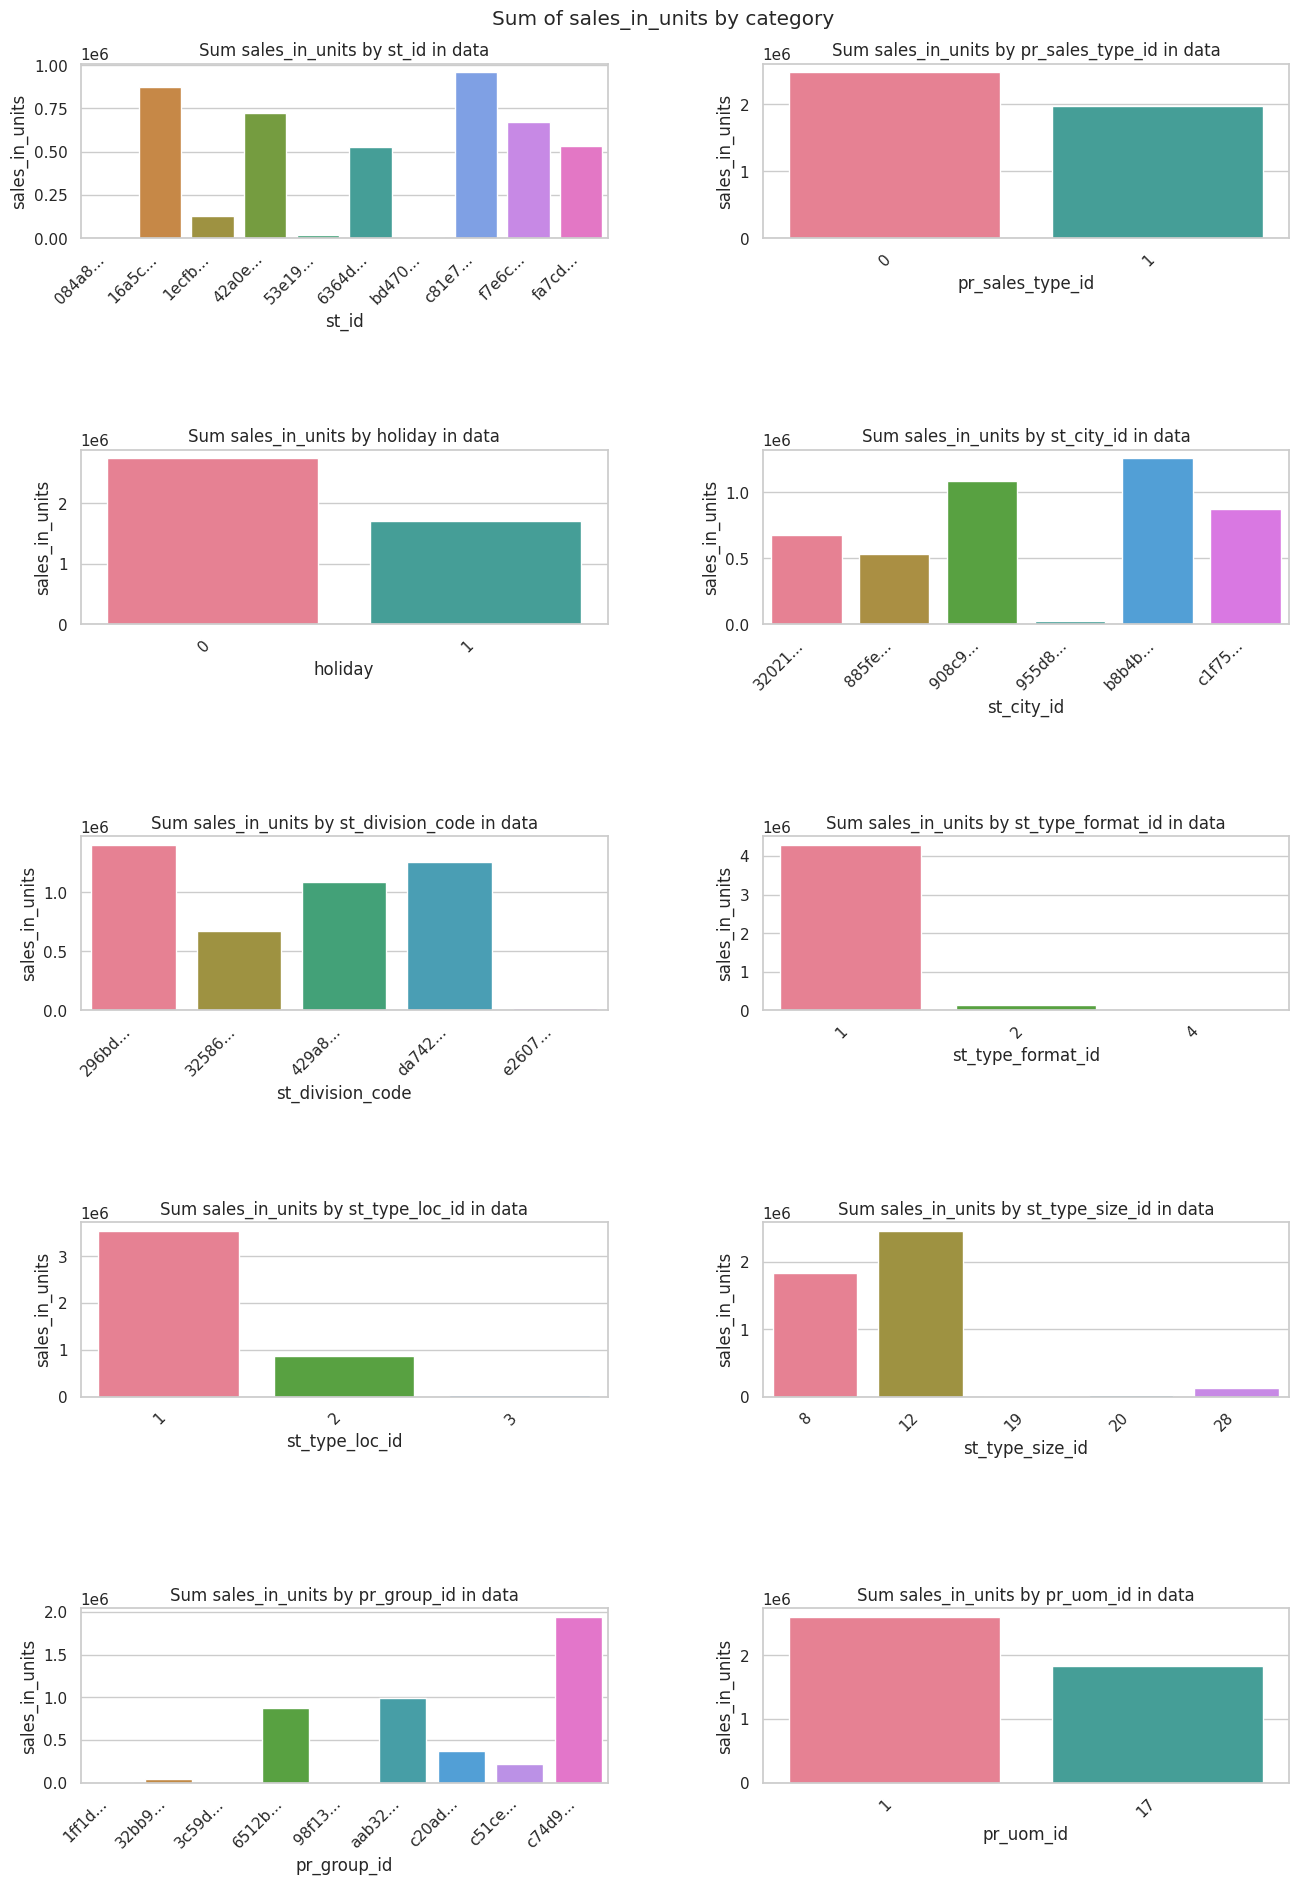

In [57]:
features_for_analysis = ['st_id',
                         'pr_sales_type_id',
                         'holiday',
                         'st_city_id',
                         'st_division_code',
                         'st_type_format_id',
                         'st_type_loc_id',
                         'st_type_size_id',
                         'pr_group_id',
                         'pr_uom_id']

fig, axs = plt.subplots(5, 2)
fig.tight_layout(pad=1.0)
fig.set_size_inches(14, 20, forward=True)

for i, col in enumerate(features_for_analysis):
    agg_df = main_df.groupby(col).agg({'pr_sales_in_units': 'sum'}).reset_index()
    agg_df = agg_df.sort_values(by=col)
    agg_df[col] = agg_df[col].astype(str)
    agg_df[col] = agg_df[col].apply(lambda x: x[:5] + '...' if len(x) > 5 else x)
    sns.barplot(x=col,
                y='pr_sales_in_units',
                data=agg_df,
                ax=axs[i // 2, i % 2],
                hue=col,
                palette=sns.color_palette("husl", len(agg_df)),
                legend=False)
    axs[i // 2, i % 2].set_title(f'Sum sales_in_units by {col} in data')
    axs[i // 2, i % 2].set_xticks(range(len(agg_df)))
    axs[i // 2, i % 2].set_xticklabels(agg_df[col], rotation=45, ha='right')
    axs[i // 2, i % 2].set_ylabel('sales_in_units')
fig.suptitle('Sum of sales_in_units by category')
plt.savefig(os.path.join(ASSETS_DIR, 'Sum of sales_in_units by category.png'))
plt.show()

Выводы и наблюдения:
- имеются магазины практически без продаж - возможно, их нужно исключить;
- есть город с практически нулевыми продажами - возможно, его необходимо исключить;
- есть дивизион с практически нулевыми продажами - возможно, его необходимо исключить;
- имеются форматы магазинов практически без продаж - возможно, их нужно исключить;
- имеются товарные группы практически без продаж - возможно, их нужно исключить;
- чтобы принять окончательное решение, необходимо детеальнее рассмотреть каждый параметр.

In [69]:
list_col = ['st_id',
            'st_city_id',
            'st_division_code',
            'st_type_format_id',
            'st_type_loc_id',
            'st_type_size_id',
            'pr_group_id']
for col in list_col:
    print(f'Распределение записей по столбцу ')
    print(main_df[col].value_counts())
    print()

Распределение записей по столбцу 
st_id
c81e728d9d4c2f636f067f89cc14862c    164779
16a5cdae362b8d27a1d8f8c7b78b4330    144017
42a0e188f5033bc65bf8d78622277c4e    128618
f7e6c85504ce6e82442c770f7c8606f0    114286
6364d3f0f495b6ab9dcf8d3b5c6e0b01    105372
fa7cdfad1a5aaf8370ebeda47a1ff1c3    100827
1ecfb463472ec9115b10c292ef8bc986     46219
53e19f3dbb211f20b20b45668303c1b6      9026
bd470ca955d9497bbcb808e59952fffc      2491
084a8a9aa8cced9175bd07bc44998e75        38
Name: count, dtype: int64

Распределение записей по столбцу 
st_city_id
b8b4b727d6f5d1b61fff7be687f7970f    233990
908c9a564a86426585b29f5335b619bc    210998
c1f75cc0f7fe269dd0fd9bd5e24f9586    144017
3202111cf90e7c816a472aaceb72b0df    114324
885fe656777008c335ac96072a45be15    100827
955d864a62659945cc9434898e275deb     11517
Name: count, dtype: int64

Распределение записей по столбцу 
st_division_code
296bd0cc6e735f9d7488ebc8fbc19130    244844
da742b3cfca5388aaf9af28a726a3c30    233990
429a86ff6336c144ddaf6144f52ab52c    

Выводы и наблюдения:
- во всех рассмотрненных признаках имеются значения с совсем небольшим количеством записей,
  <br>но пока их исключать нет необходимости;
- вернуться к ним можно на следующих шагах исследования.

#### target analysis

Описательные статистики целевой переменной:


count    815673.000000
mean          5.451414
std          13.864076
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max        2348.000000
Name: pr_sales_in_units, dtype: float64

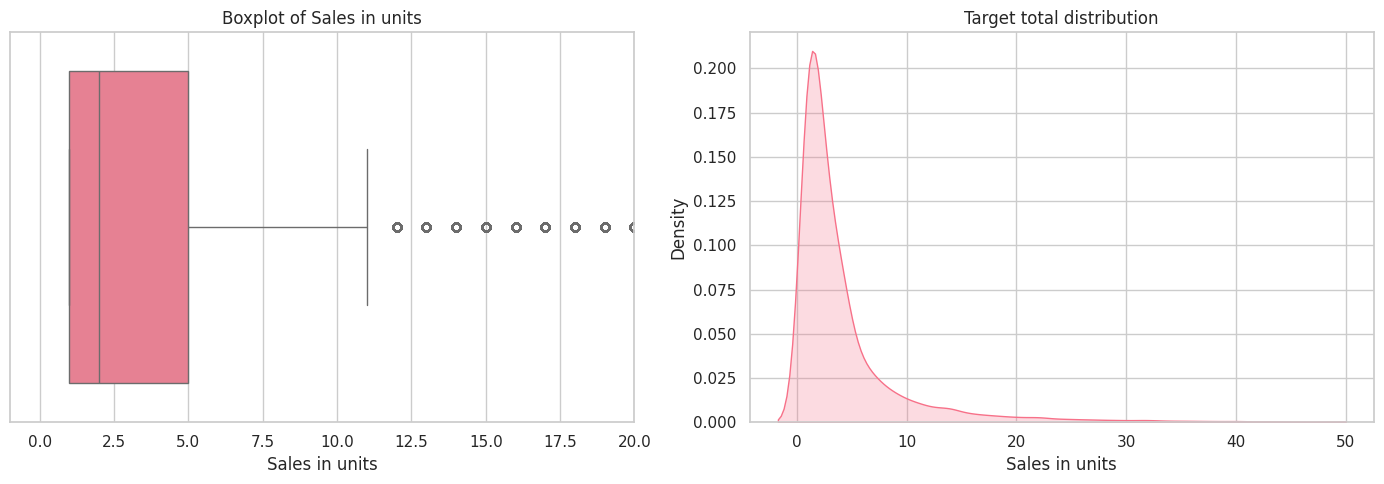

In [85]:
print('Описательные статистики целевой переменной:')
display(main_df['pr_sales_in_units'].describe())
print()

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(data=main_df, x='pr_sales_in_units', ax=axs[0])
axs[0].set_xlim(-1, 20)
axs[0].set_xlabel('Sales in units')
axs[0].set_title('Boxplot of Sales in units')

sns.kdeplot(data=main_df, x='pr_sales_in_units', clip=(-10, 50), fill=True, ax=axs[1])
axs[1].set_xlabel('Sales in units')
axs[1].set_title('Target total distribution')

plt.tight_layout()
plt.savefig(os.path.join(ASSETS_DIR, 'Target total distribution and boxplot.png'))
plt.show()

Выводы и наблюдения:
- Cреднее значение больше медианного, наблюдается правосторонняя асимметрия;
- распределение целевой переменной `pr_sales_in_units` отличается от нормального.

#### feature correlation matrix

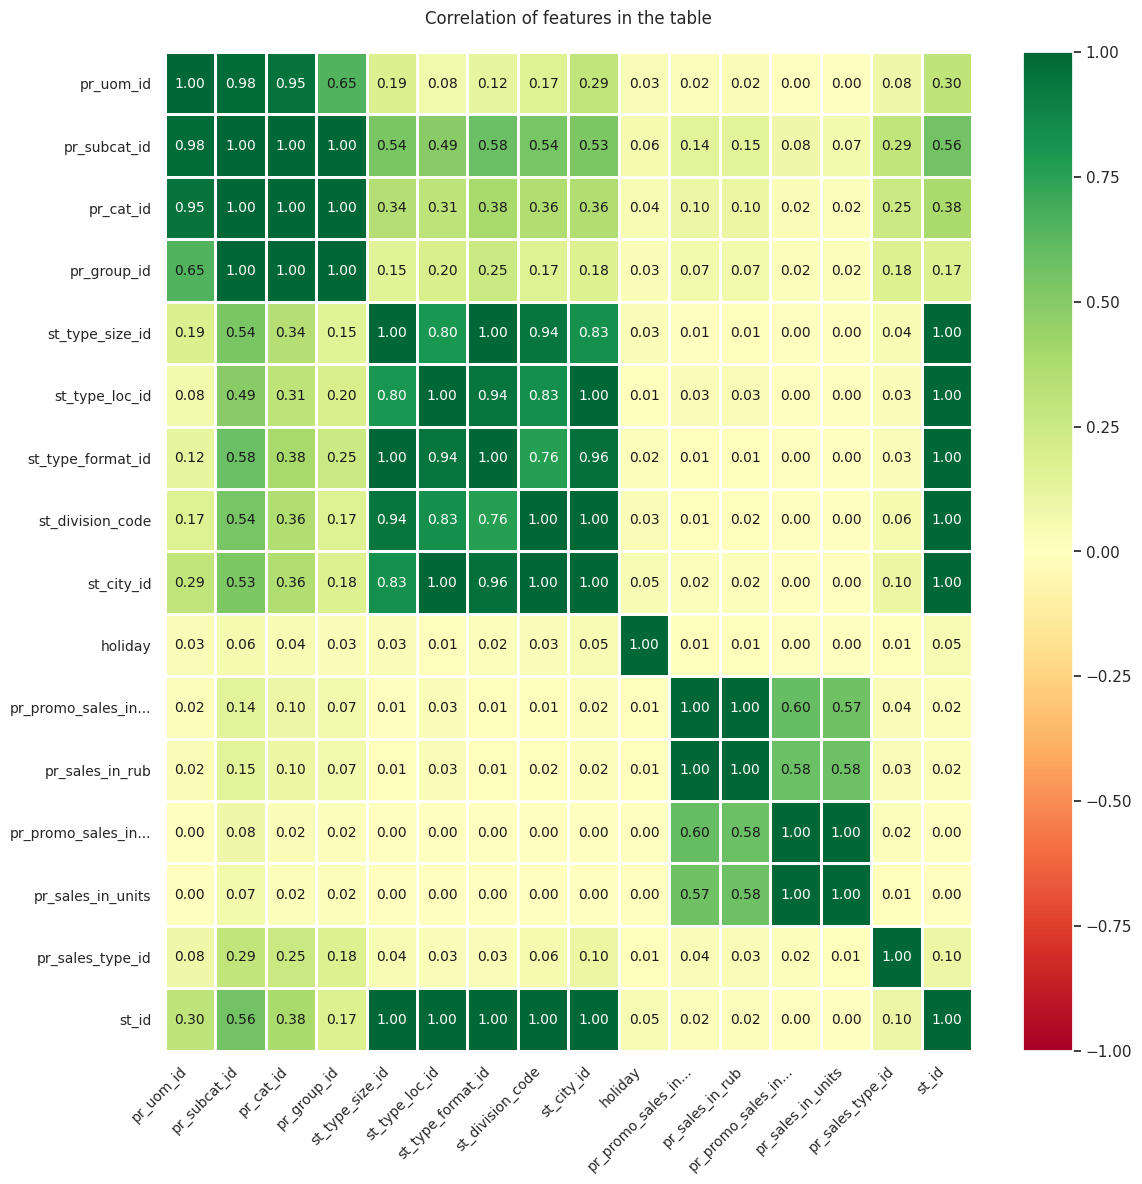

In [18]:
phik_overview = (
    main_df.drop(columns=['pr_sku_id', 'date', 'covid', 'st_is_active'])
    .phik_matrix(interval_cols=main_df.select_dtypes(include=['int', 'float'])))
sns.set()
plot_correlation_matrix(phik_overview.values,
						x_labels=phik_overview.columns,
						y_labels=phik_overview.index,
						fontsize_factor=1.0,
						figsize=(12, 12))
plt.xticks(rotation=45, ha='right')
plt.title(f'Correlation of features in the table', fontsize=12, y=1.02)
plt.savefig(os.path.join(ASSETS_DIR, 'Features correlations.png'))
plt.tight_layout()

Выводы и наблюдения:
- группы признаков, у которых выявлены корреляции:
  - `st_id`, `st_type_size_id`, `st_type_loc_id`, `st_type_format_id`, `st_division_code`, `st_city_id`;
  - `pr_promo_sales_in_units`, `pr_sales_in_units`, `pr_sales_in_rub`, `pr_promo_sales_in_rub`;
  - `pr_uom_id`, `pr_subcat_id`, `pr_cat_id`;
- в каждой группе будет оставлен только один признак.

Удаление неинформативных и коррелированных признаков

In [23]:
clean_df = main_df.copy()
clean_df.drop(['st_is_active',
               'covid',
               'pr_promo_sales_in_units',
               'pr_sales_in_rub',
               'pr_promo_sales_in_rub',
               'pr_subcat_id',
               'pr_cat_id',
               'st_type_size_id',
               'st_type_loc_id',
               'st_type_format_id',
               'st_division_code',
               'st_city_id'],
              axis=1,
              inplace=True)

In [6]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815673 entries, 0 to 815672
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   st_id              815673 non-null  object        
 1   pr_sku_id          815673 non-null  object        
 2   date               815673 non-null  datetime64[ns]
 3   pr_sales_type_id   815673 non-null  int64         
 4   pr_sales_in_units  815673 non-null  float64       
 5   holiday            815673 non-null  int64         
 6   pr_group_id        815673 non-null  object        
 7   pr_uom_id          815673 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 49.8+ MB


### checkpoint_2

In [4]:
# clean_df.to_csv('data/df_1.csv', index=False)
clean_df = pd.read_csv('data/df_1.csv', parse_dates=['date'])

#### distribution of target by date

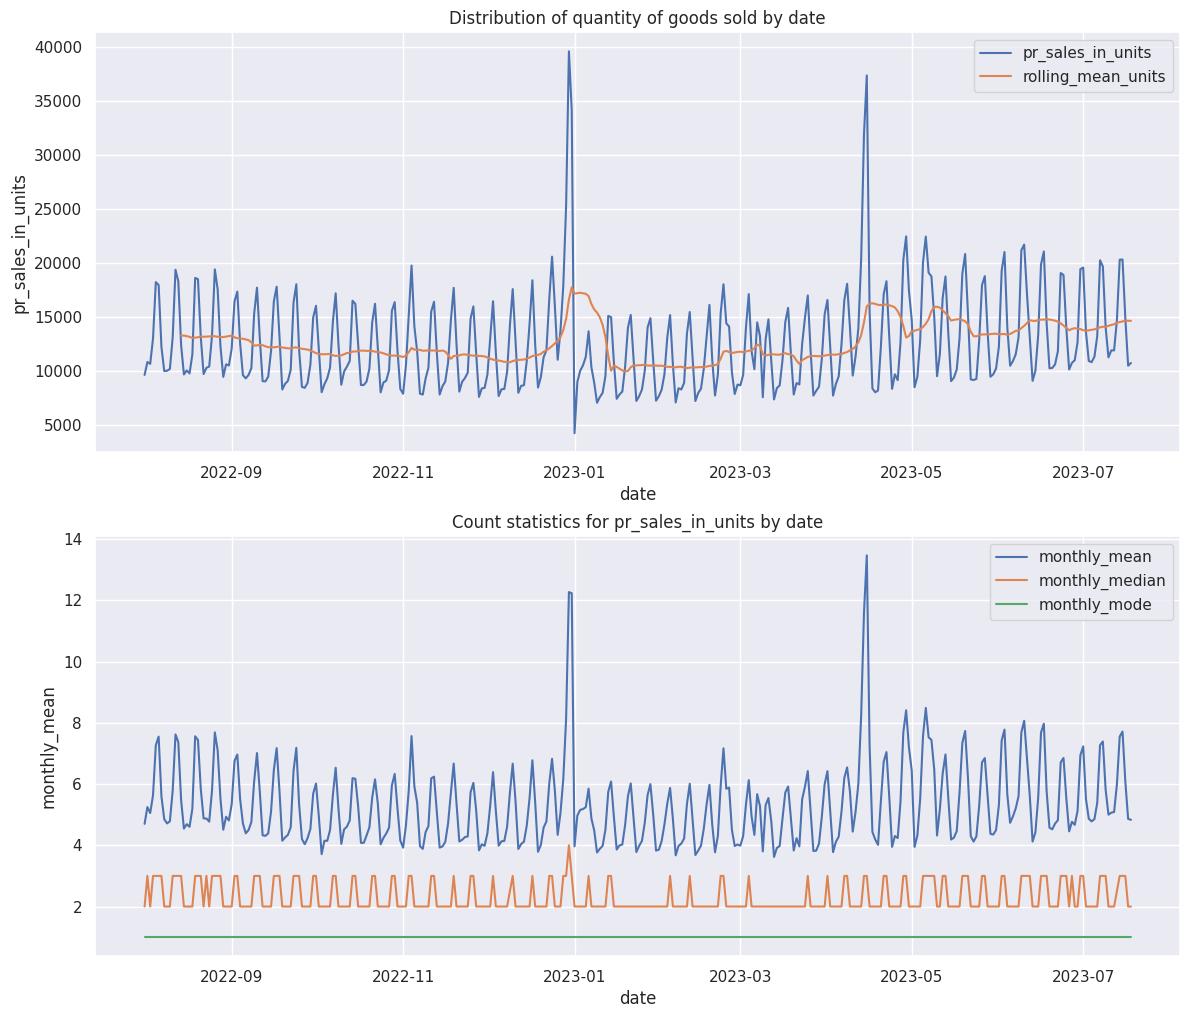

In [28]:
target_agg_by_date = clean_df[['date', 'pr_sales_in_units']].groupby(['date']).agg(['sum']).reset_index()
target_agg_by_date.columns = target_agg_by_date.columns.droplevel()
target_agg_by_date.columns = ['date', 'pr_sales_in_units']
target_agg_by_date['rolling_mean_units'] = target_agg_by_date['pr_sales_in_units'].rolling(14).mean()
x = 'date'
sales_columns = ['pr_sales_in_units', 'rolling_mean_units']
stats = ['mean', 'median', lambda x: x.mode().iloc[0]]

sales_monthly_agg = clean_df[[x] + [sales_columns[0]]].groupby([x]).agg(stats).reset_index()
sales_monthly_agg.columns = sales_monthly_agg.columns.droplevel()
sales_monthly_agg.columns = [x, "monthly_mean", "monthly_median", "monthly_mode"]

fig, axs = plt.subplots(2, 1, figsize=(14, 12))

for col in sales_columns:
    sns.lineplot(data=target_agg_by_date, x='date', y=col, label=col, ax=axs[0])
axs[0].set_title('Distribution of quantity of goods sold by date')
axs[0].legend()

for i, stat in enumerate(sales_monthly_agg.columns[1:]):
    sns.lineplot(data=sales_monthly_agg, x=x, y=stat, label=stat, ax=axs[1])
axs[1].set_title(f"Count statistics for {sales_columns[0]} by {x}")
axs[1].legend()

plt.savefig(os.path.join(ASSETS_DIR, 'Target statistics by date.png'))
plt.show()

Выводы и наблюдения:
- самые большие суммарные продажи в конце декабря, начеле января и в апреле,
  <br>это же демонстрирует и скользящее среднее;
- самое низкое значение продаж в начале января;
- медианное значение по месяцам колеблется в интервале от 2-х до 3-х;
- мода - везде равна единице.

#### resampling by sums of values per day

In [5]:
clean_df_dt = clean_df.set_index('date')
clean_df_resamp = clean_df_dt.resample('1D').sum()

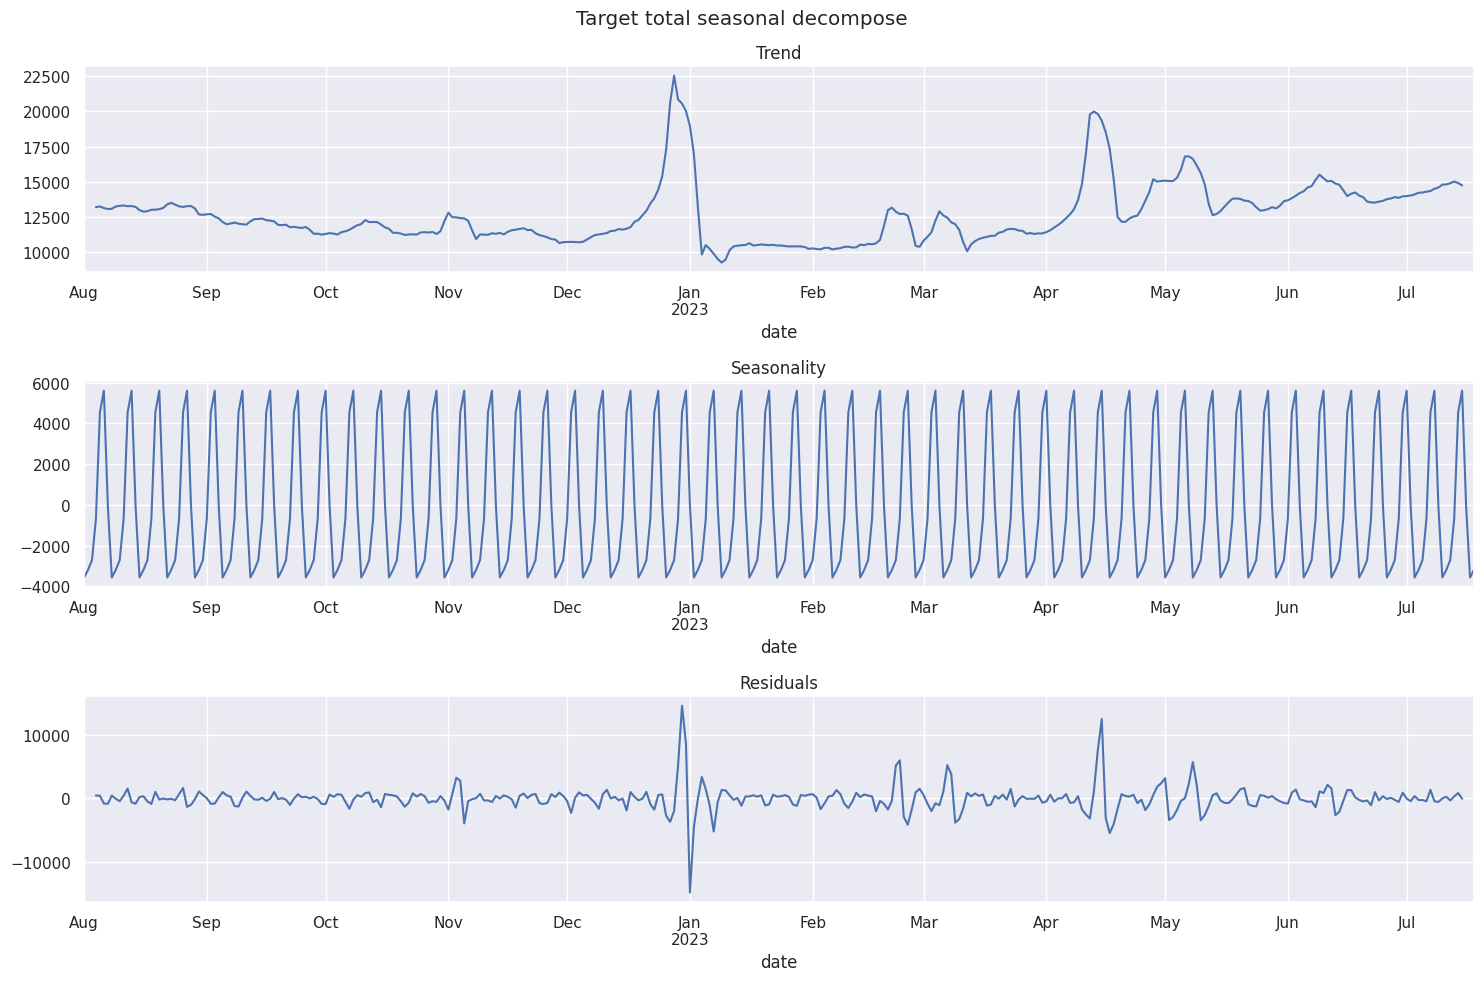

In [61]:
decomposed_units = seasonal_decompose(clean_df_resamp['pr_sales_in_units'])

plt.figure(figsize=(15,10))
plt.subplot(311)
decomposed_units.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_units.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_units.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.suptitle('Target total seasonal decompose')
plt.savefig(os.path.join(ASSETS_DIR, 'Target total seasonal decompose.png'))
plt.tight_layout()
plt.show()

Выводы и наблюдения:
- На графике тренда наблюдается, рост продаж в дни государственных праздников:
  <br>Новый год, 23 февраля, 8 марта, майские праздники, 12 июня - в эти дни образуются локальные пики;
- Самый большой пик продаж в конце декабря, в первые несколько дней января  спрос резко падает.
  <br>Это связано с подготовкой покупателей к корпоративам и празднованию Нового года.
- После первой декады апреля и до начала сентября продажи выше, чем в остальную часть года.
  <br>Это связано с сезоном пикников и  поездками на дачи.

#### study of seasonality over a fortnight interval

In [6]:
fortnight_season = clean_df_resamp['pr_sales_in_units']
fortnight_season = fortnight_season['2023-06-24':'2023-07-11']

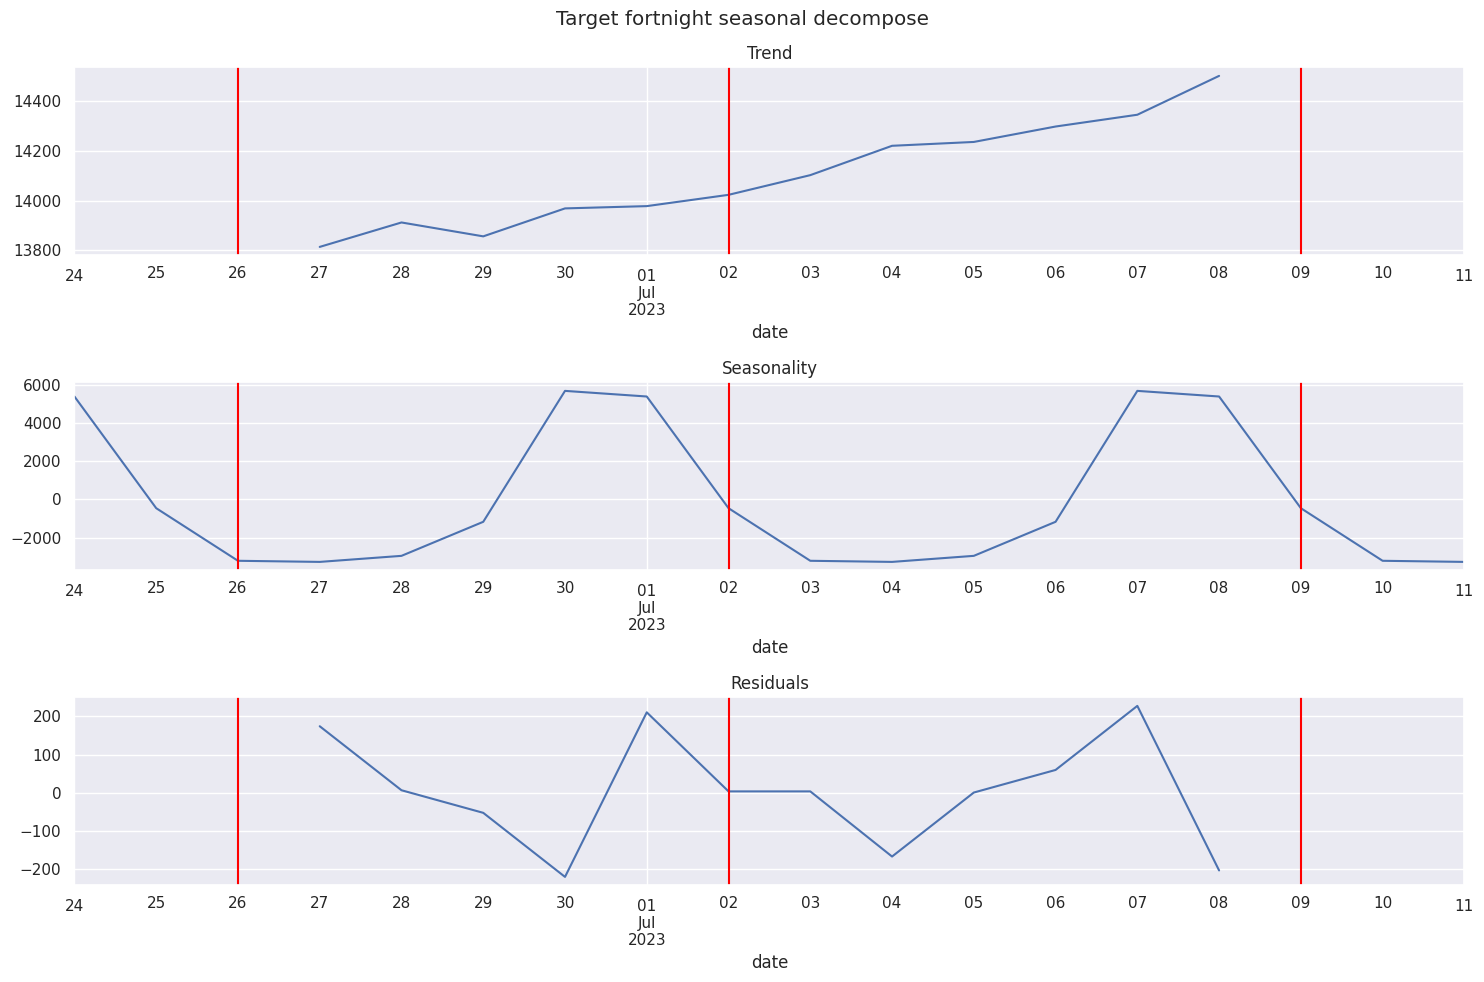

In [63]:
decomposed_week = seasonal_decompose(fortnight_season)

plt.figure(figsize=(15,10))

plt.subplot(311)
decomposed_week.trend.plot(ax=plt.gca())
plt.axvline(x='2023-06-26', color='red', label='axvline - full height')
plt.axvline(x='2023-07-02', color='red', label='axvline - full height')
plt.axvline(x='2023-07-9', color='red', label='axvline - full height')
plt.title('Trend')

plt.subplot(312)
decomposed_week.seasonal.plot(ax=plt.gca())
plt.axvline(x='2023-06-26', color='red', label='axvline - full height')
plt.axvline(x='2023-07-02', color='red', label='axvline - full height')
plt.axvline(x='2023-07-9', color='red', label='axvline - full height')
plt.title('Seasonality')

plt.subplot(313)
decomposed_week.resid.plot(ax=plt.gca())
plt.axvline(x='2023-06-26', color='red', label='axvline - full height')
plt.axvline(x='2023-07-02', color='red', label='axvline - full height')
plt.axvline(x='2023-07-9', color='red', label='axvline - full height')
plt.title('Residuals')

plt.suptitle('Target fortnight seasonal decompose')
plt.savefig(os.path.join(ASSETS_DIR, 'Target fortnight seasonal decompose.png'))
plt.tight_layout()
plt.show()

Выводы и наблюдения:
- При анализе тренда за 2 недели наблюдается, рост продаж в пятницу и субботу,
- в воскресенье отмечается спад.
- Уровень продаж в течение недели ниже, чем в пиковые дни.
- Клиенты чаще совершают покупки перед выходными днями и в выходные.

#### stationarity check

In [65]:
test = adfuller(clean_df_resamp['pr_sales_in_units'])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0] > test[4]['5%']:
  print('есть единичные корни, ряд не стационарен')
else:
  print('единичных корней нет, можем предположить, что ряд стационарен')

adf:  -3.3035023987078924
p-value:  0.014722641217042629
Critical values:  {'1%': -3.4499043309021955, '5%': -2.870154885338925, '10%': -2.5713597190254385}
единичных корней нет, можем предположить, что ряд стационарен


Вывод по тесту Дики-Фуллера:
- Исходя из данного результата теста Дики-Фуллера, можно сделать вывод,
  <br>что временной ряд является стационарным, так как p-значение меньше уровня значимости 0.05,
  <br>и статистика теста меньше критических значений для всех уровней значимости.

### conclusions from the eda
- Данные предоставлены за период с 01.08.2022 по 18.07.2023
- Предоставленные датасеты объединены в один датафрейм
- К общему датафрейму добавлена информация о государственных праздниках и выходных днях в РФ
- Удалены записи по магазинам без маркера активности (действие согласовано с бизнесом): им соответствует 729 записей, что составляет 0.08% датасета.
- Распределение целевой переменной `pr_sales_in_units` отличается от нормального: наблюдается правосторонняя асимметрия
- Удалены данные с нулевыми продажами в шт и руб.
- Удалены записи с отрицательным значением целевого признака (действие согласовано с бизнесом)
- Удалены сильно коррелированные признаки
- Данные разложены на три составляющие (для этого осуществлён ресемплинг по одному дню) - сезонность, тренд и остаток:
  - наблюдается рост спроса перед праздничными днями (годовая сезонность)
  - рост спроса в выходные дни (недельная сезонность)
- Временной ряд может быть стационарен, о чём свидетельствует тест Дики-Фуллера, но наличие тренда и сезонности говорят об обратном

## Baseline

### data prepare

Деление данных на выборки

In [7]:
X_train, y_train, X_test, y_test = DatasetExplorer.data_splitting(dataset=clean_df_dt, pred_period=DAYS_PRED, target='pr_sales_in_units')

Размерности полученных выборок:


(781525, 6)

(781525,)

(34148, 6)

(34148,)

In [8]:
tscv = TimeSeriesSplit(n_splits=math.floor(X_train.shape[0] / X_test.shape[0]))
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=22, test_size=None)

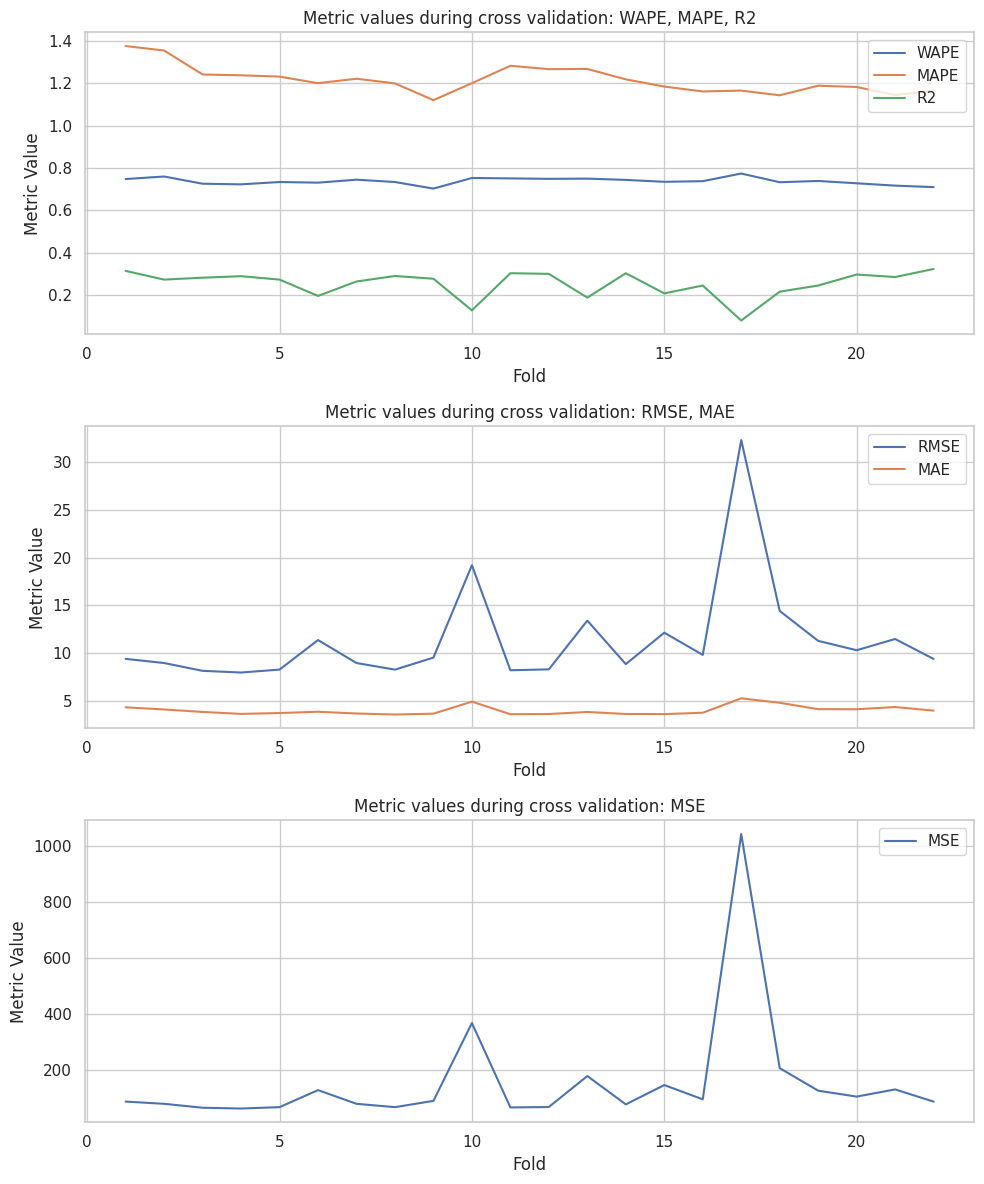

Средние значения метрик по кросс-валидации:


{'wape': 0.738,
 'mape': 1.216,
 'rmse': 11.354,
 'mae': 3.992,
 'mse': 156.518,
 'r2': 0.255}

In [9]:
valid_metrics, pipeline = DatasetExplorer.model_fitting(model_name='Baseline',
                                                        train_features=X_train,
                                                        train_labels=y_train,
                                                        assets_dir=ASSETS_DIR,
                                                        tscv=tscv,
                                                        params=None,
                                                        params_selection=False)

In [43]:
metadata = {"data_used": 'clean_df',
            "library_versions": {"mlflow": "2.12.2",
                                 "category-encoders": "2.6.3",
                                 "scikit-learn":"1.4.2"}
           }
code_paths = ['demand_forecast.ipynb', 'regression_research_class.py']
sales_explorer.model_logging(experiment_name=EXPERIMENT_NAME,
					         run_name='baseline_cv_registry',
					         registry_model='baseline_cv',
					         params=pipeline.named_steps['model'].get_params(),
					         metrics=valid_metrics,
					         model=pipeline.named_steps['model'],
					         train_data=X_train,
                             train_label=y_train,
					         assets_dir=ASSETS_DIR,
					         metadata=metadata,
					         code_paths=code_paths,
					         tsh=TRACKING_SERVER_HOST,
					         tsp=TRACKING_SERVER_PORT)

Successfully registered model 'baseline_cv'.
2024/05/16 22:18:16 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: baseline_cv, version 1
Created version '1' of model 'baseline_cv'.


Models and their metrics:


,experiment_name,run_name,model_name,model_version,wape,mape,rmse,mae,mse,r2
0,lenta_demand_forecast,baseline_0_registry,baseline,1,0.891,1.811,12.548,5.117,157.442,0.045
1,lenta_demand_forecast,baseline_cv_registry,baseline_cv,1,0.893,1.778,12.801,4.832,191.194,0.031


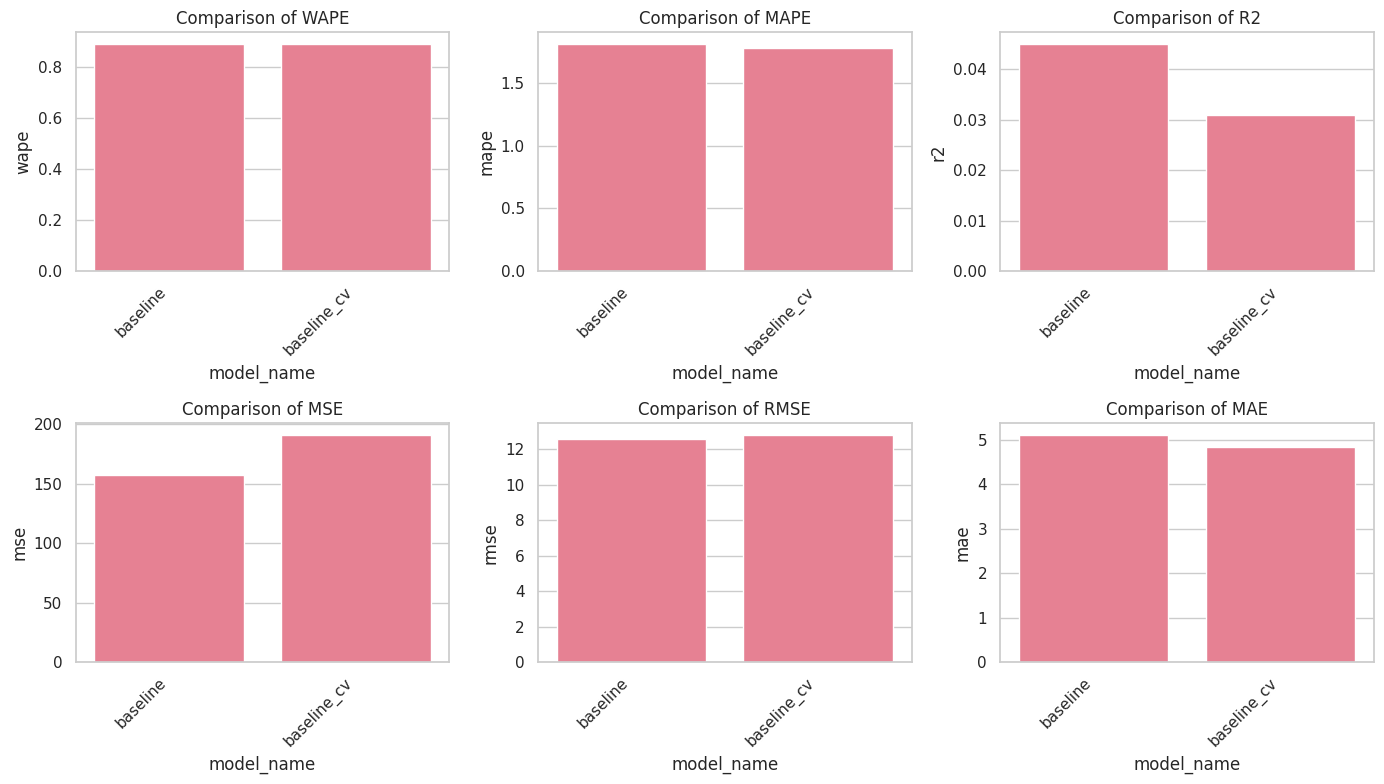

In [44]:
sales_explorer.models_comparison(connection=connection,
                                 postgres_credentials=postgres_credentials,
                                 experiment_name=EXPERIMENT_NAME,
                                 assets_dir=None)

Выводы и наблюдения:
- данные разделены на выборки;
- создан объект `TimeSeriesSplit`;
- в качестве базовой модели принята модель `LinearRegression`;
- значение метрики на базовой модели: `wape = 0.893`

## Feature engineering

In [10]:
df_new_feat = DatasetExplorer.feature_engineering(dataset=clean_df,
                                                  target='pr_sales_in_units',
                                                  date_column='date',
                                                  group_columns=['st_id', 'pr_sku_id', 'pr_sales_type_id'],
                                                  window_size=14)

Верхние строки набора данных:


,st_id,pr_sku_id,pr_sales_type_id,pr_sales_in_units,holiday,pr_group_id,pr_uom_id,rolling_mean_14d_lag3,rolling_mean_14d_lag7,rolling_mean_14d_lag11,rolling_mean_14d_lag14,month,day,day_of_year,day_of_week,quarter,is_month_start,is_month_end
date,,,,,,,,,,,,,,,,,,
2022-08-01,6364d3f0f495b6ab9dcf8d3b5c6e0b01,e4522fed8db6c62127eedea2fe1634bd,0,1.0,0,c74d97b01eae257e44aa9d5bade97baf,17,6.0,6.0,1.0,1.0,8,1,213,0,3,1,0
2022-08-01,42a0e188f5033bc65bf8d78622277c4e,98d292620ce4e8087db271b691e28a4c,0,2.0,0,c51ce410c124a10e0db5e4b97fc2af39,1,2.0,1.0,2.0,3.0,8,1,213,0,3,1,0
2022-08-01,16a5cdae362b8d27a1d8f8c7b78b4330,b6871caaf03565202e4c3bafef2af7c6,0,1.0,0,c74d97b01eae257e44aa9d5bade97baf,1,1.0,3.0,2.0,4.0,8,1,213,0,3,1,0
2022-08-01,1ecfb463472ec9115b10c292ef8bc986,71548e4c1872755e6873416c2f49afe4,0,1.0,0,aab3238922bcc25a6f606eb525ffdc56,1,1.0,4.0,1.0,1.0,8,1,213,0,3,1,0
2022-08-01,16a5cdae362b8d27a1d8f8c7b78b4330,67797f1f0f02ec5ccd5e3abd2d4e5b81,0,17.0,0,aab3238922bcc25a6f606eb525ffdc56,1,2.0,6.0,6.0,2.0,8,1,213,0,3,1,0


Выводы и заключения:
- сгенерированы новые признаки из составляющих даты;
- сгенерированы новые признаки из лагов скользящего среднего за 14 дней.

## Linear Regression with all features

In [11]:
X_train, y_train, X_test, y_test = DatasetExplorer.data_splitting(dataset=df_new_feat,
                                                                  pred_period=DAYS_PRED,
                                                                  target='pr_sales_in_units')

Размерности полученных выборок:


(781511, 17)

(781511,)

(34148, 17)

(34148,)

In [12]:
tscv = TimeSeriesSplit(n_splits=math.floor(X_train.shape[0] / X_test.shape[0]))
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=22, test_size=None)

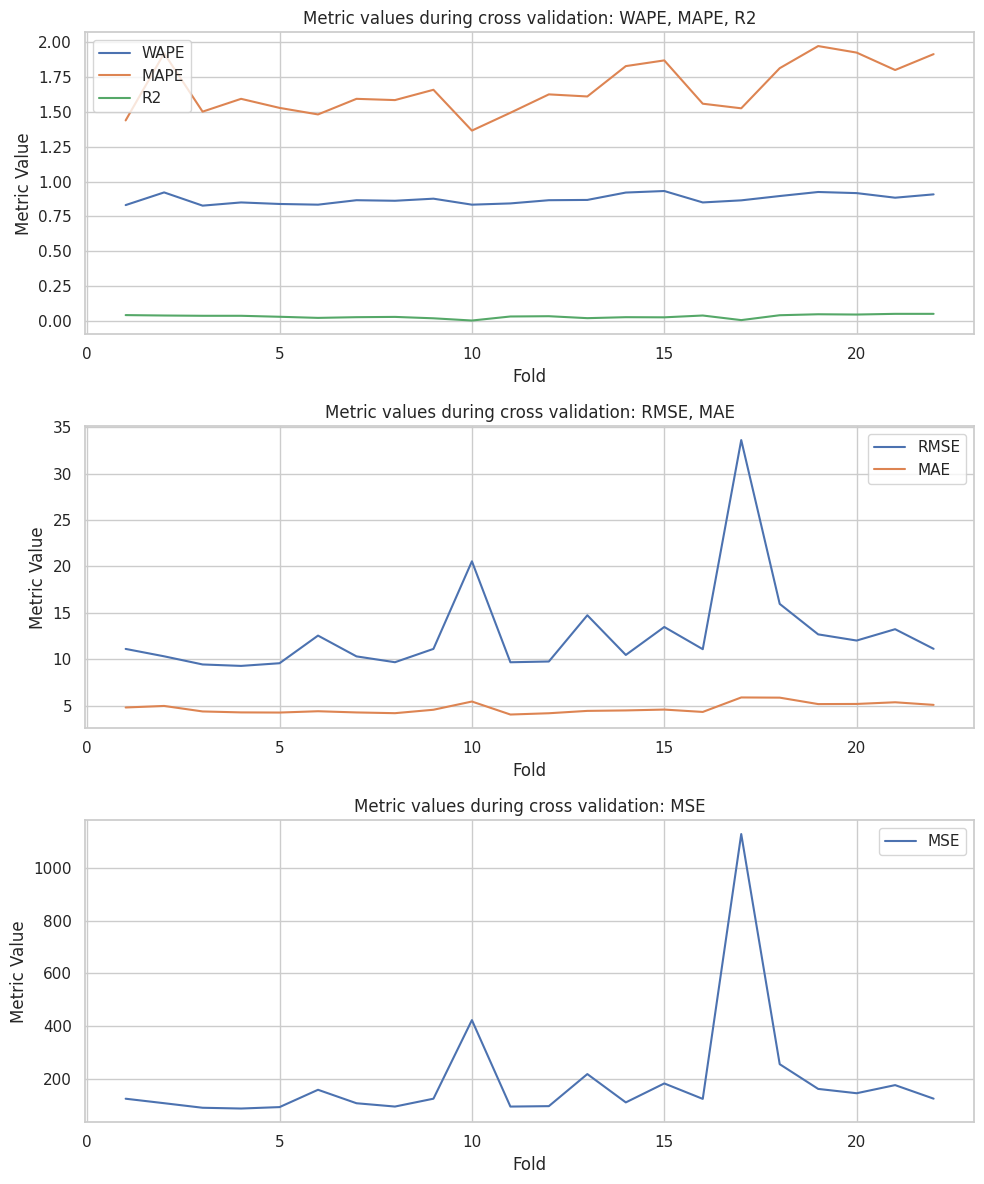

Средние значения метрик по кросс-валидации:


{'wape': 0.874,
 'mape': 1.664,
 'rmse': 12.801,
 'mae': 4.726,
 'mse': 191.185,
 'r2': 0.031}

In [13]:
valid_metrics, pipeline = DatasetExplorer.model_fitting(model_name='Linear Regression',
                                                        train_features=X_train.drop(['pr_sku_id'], axis=1),
                                                        train_labels=y_train,
                                                        assets_dir=None,
                                                        tscv=tscv,
                                                        params=None,
                                                        params_selection=False)

In [112]:
metadata = {"data_used": 'df_new_feat',
            "library_versions": {"mlflow": "2.12.2",
                                 "category-encoders": "2.6.3",
                                 "scikit-learn":"1.4.2"}
           }
code_paths = ['demand_forecast.ipynb', 'regression_research_class.py']
sales_explorer.model_logging(experiment_name=EXPERIMENT_NAME,
					         run_name='linreg_cv_0_registry',
					         registry_model='linreg_cv',
					         params=pipeline.named_steps['model'].get_params(),
					         metrics=valid_metrics,
					         model=pipeline.named_steps['model'],
					         train_data=X_train,
                             train_label=y_train,
					         assets_dir=ASSETS_DIR,
					         metadata=metadata,
					         code_paths=code_paths,
					         tsh=TRACKING_SERVER_HOST,
					         tsp=TRACKING_SERVER_PORT)

Successfully registered model 'linreg_cv'.
2024/05/17 18:42:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: linreg_cv, version 1
Created version '1' of model 'linreg_cv'.


Models and their metrics:


,experiment_name,run_name,model_name,model_version,wape,mape,rmse,mae,mse,r2
0,lenta_demand_forecast,linreg_cv_0_registry,linreg_cv,1,0.874,1.664,12.801,4.727,191.186,0.031
1,lenta_demand_forecast,baseline_0_registry,baseline,1,0.891,1.811,12.548,5.117,157.442,0.045
2,lenta_demand_forecast,baseline_cv_registry,baseline_cv,1,0.893,1.778,12.801,4.832,191.194,0.031


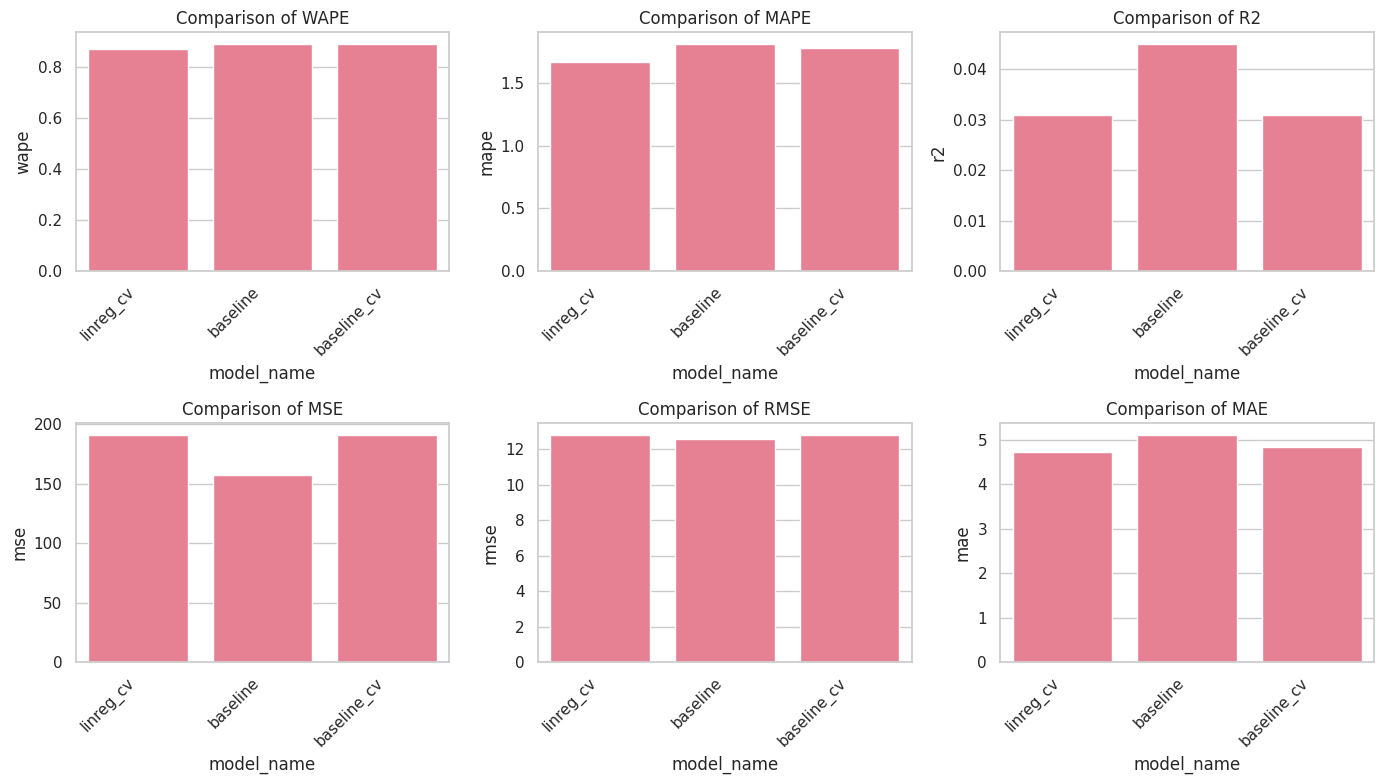

In [113]:
sales_explorer.models_comparison(connection=connection,
                                 postgres_credentials=postgres_credentials,
                                 experiment_name=EXPERIMENT_NAME,
                                 assets_dir=None)

Выводы и наблюдения:
- модель линейной регрессии, обученная на наборе данных с добавленными признаками,
  <br>показала чуть лучший результат: `wape = 0.874`

## LightGBM

/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 33995, number of used features: 13
[LightGBM] [Info] Start training from score 5.799971
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 67973, number of used features: 14
[LightGBM] [Info] Start training from score 5.786312
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 101951, number of used features: 15
[LightGBM] [Info] Start training from score 5.651519
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1650
[LightGBM] [Info] Number of data points in the train set: 135929, number of used features: 15
[LightGBM] [Info] Start training from score 5.559057
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1668
[LightGBM] [Info] Number of data points in the train set: 169907, number of used features: 16
[LightGBM] [Info] Start training from score 5.450858
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1683
[LightGBM] [Info] Number of data points in the train set: 203885, number of used features: 16
[LightGBM] [Info] Start training from score 5.386532
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1699
[LightGBM] [Info] Number of data points in the train set: 237863, number of used features: 16
[LightGBM] [Info] Start training from score 5.368742
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1714
[LightGBM] [Info] Number of data points in the train set: 271841, number of used features: 16
[LightGBM] [Info] Start training from score 5.313117
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1730
[LightGBM] [Info] Number of data points in the train set: 305819, number of used features: 16
[LightGBM] [Info] Start training from score 5.262011
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1744
[LightGBM] [Info] Number of data points in the train set: 339797, number of used features: 16
[LightGBM] [Info] Start training from score 5.254973
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1761
[LightGBM] [Info] Number of data points in the train set: 373775, number of used features: 16
[LightGBM] [Info] Start training from score 5.370081
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1777
[LightGBM] [Info] Number of data points in the train set: 407753, number of used features: 16
[LightGBM] [Info] Start training from score 5.321857
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1793
[LightGBM] [Info] Number of data points in the train set: 441731, number of used features: 16
[LightGBM] [Info] Start training from score 5.283480
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 475709, number of used features: 16
[LightGBM] [Info] Start training from score 5.270420
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1823
[LightGBM] [Info] Number of data points in the train set: 509687, number of used features: 16
[LightGBM] [Info] Start training from score 5.243330
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 543665, number of used features: 16
[LightGBM] [Info] Start training from score 5.222271
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 577643, number of used features: 16
[LightGBM] [Info] Start training from score 5.213689
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 611621, number of used features: 16
[LightGBM] [Info] Start training from score 5.301304
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 645599, number of used features: 16
[LightGBM] [Info] Start training from score 5.366441
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 679577, number of used features: 16
[LightGBM] [Info] Start training from score 5.377132
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1851
[LightGBM] [Info] Number of data points in the train set: 713555, number of used features: 16
[LightGBM] [Info] Start training from score 5.390039
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 747533, number of used features: 16
[LightGBM] [Info] Start training from score 5.420403
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


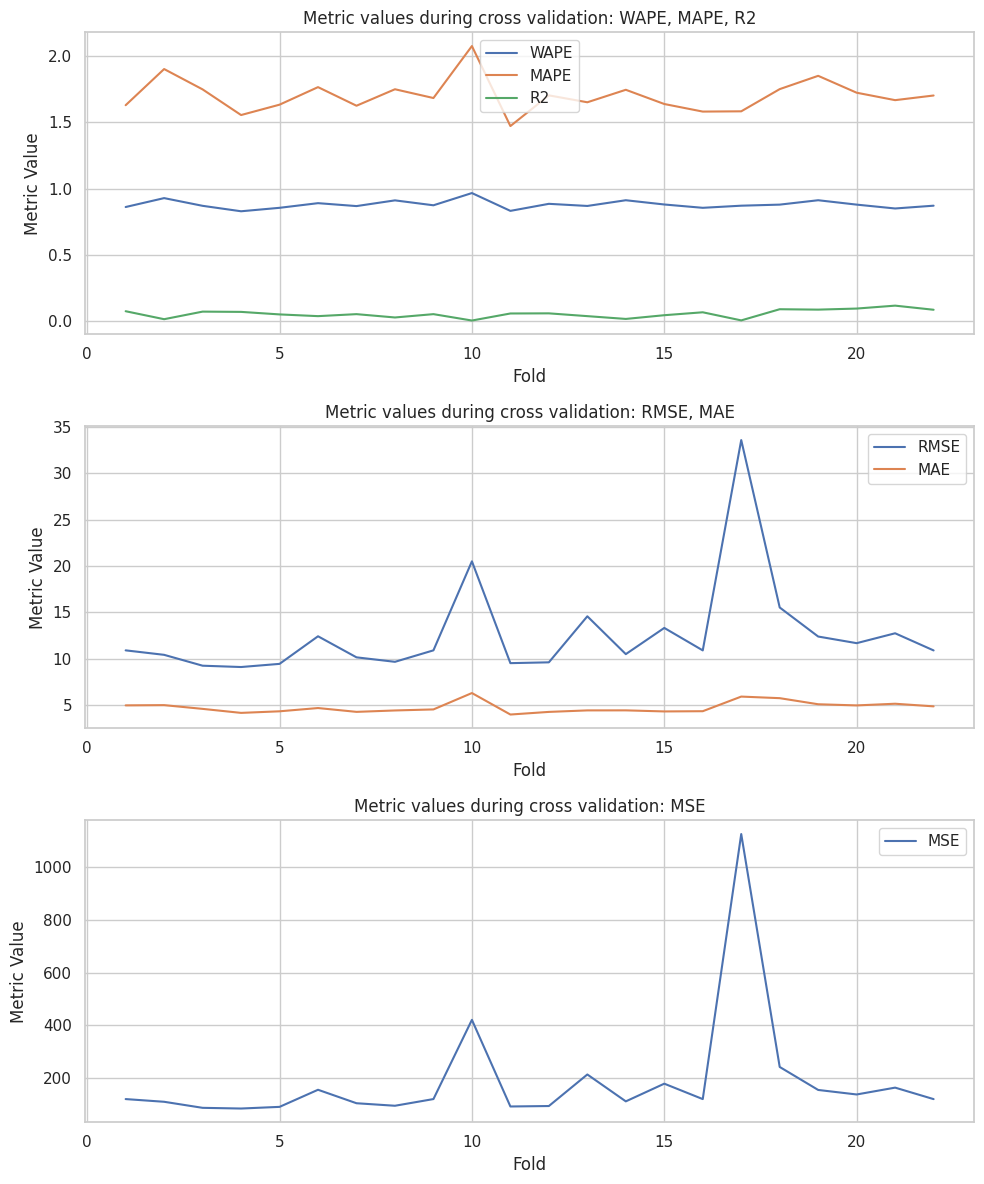

Средние значения метрик по кросс-валидации:


{'wape': 0.879,
 'mape': 1.699,
 'rmse': 12.634,
 'mae': 4.763,
 'mse': 187.008,
 'r2': 0.058}

In [14]:
lgb_params = {'num_iterations': 100,
              'learning_rate': 0.1,
              'num_leaves': 31,
              'boosting': 'gbdt',
              'seed': RANDOM_STATE,
              'num_threads': 0}
lgb_metrics, lgb_pipeline = DatasetExplorer.model_fitting(model_name='LGBM',
                                                          train_features=X_train.drop(['pr_sku_id'], axis=1),
                                                          train_labels=y_train,
                                                          assets_dir=None,
                                                          tscv=tscv,
                                                          params=lgb_params,
                                                          params_selection=False)

In [19]:
metadata = {"data_used": "df_new_feat",
            "library_versions": {"mlflow": "2.12.2",
                                 "category-encoders": "2.6.3",
                                 "scikit-learn": "1.4.2",
                                 "lightgbm": "4.4.0"}
           }
code_paths = ['demand_forecast.ipynb', 'regression_research_class.py']
sales_explorer.model_logging(experiment_name=EXPERIMENT_NAME,
					         run_name='lgbm_0_registry',
					         registry_model='lgbm_base',
					         params=lgb_pipeline.named_steps['model'].get_params(),
					         metrics=lgb_metrics,
					         model=lgb_pipeline.named_steps['model'],
					         train_data=X_train,
                             train_label=y_train,
					         assets_dir=ASSETS_DIR,
					         metadata=metadata,
					         code_paths=code_paths,
					         tsh=TRACKING_SERVER_HOST,
					         tsp=TRACKING_SERVER_PORT)

[autoreload of regression_research_class failed: Traceback (most recent call last):
  File "/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/denis/Documents/main_venv/demand_forecast_lenta/regression_research_class.py", line 30, in <module>
    class DatasetExplorer:
  File "/home/denis/Documents/main_venv/demand_forecast_lenta/r

Models and their metrics:


,experiment_name,run_name,model_name,model_version,wape,mape,rmse,mae,mse,r2
0,lenta_demand_forecast,linreg_cv_0_registry,linreg_cv,1,0.874,1.664,12.801,4.727,191.186,0.031
1,lenta_demand_forecast,lgbm_0_registry,lgbm_base,1,0.879,1.699,12.634,4.763,187.008,0.058
2,lenta_demand_forecast,baseline_0_registry,baseline,1,0.891,1.811,12.548,5.117,157.442,0.045
3,lenta_demand_forecast,baseline_cv_registry,baseline_cv,1,0.893,1.778,12.801,4.832,191.194,0.031


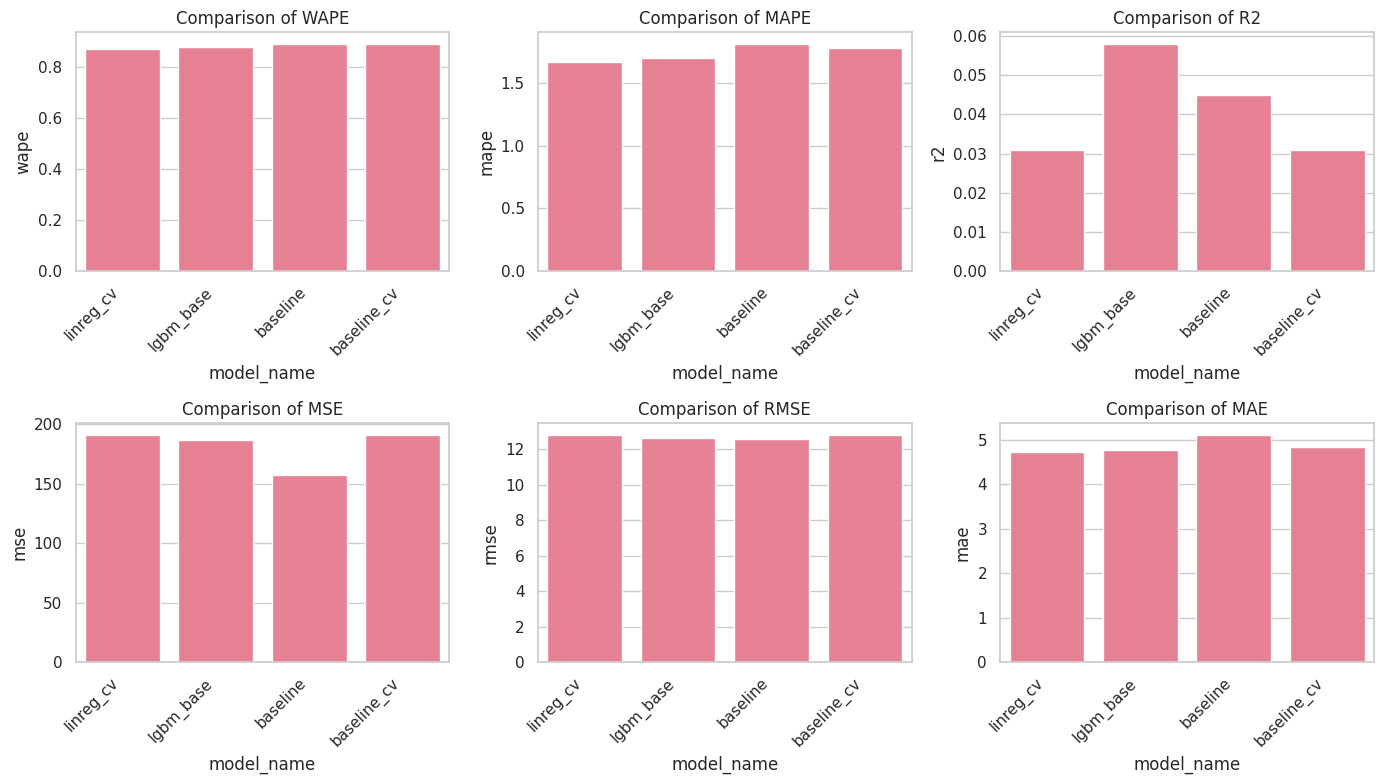

In [15]:
DatasetExplorer.models_comparison(connection=connection,
                                  postgres_credentials=postgres_credentials,
                                  experiment_name=EXPERIMENT_NAME,
                                  assets_dir=None)

Выводы и наблюдения:

- модель градиентного бустинга, обученная на наборе данных с гиперпараметрами по умолчанию,
  <br>показала не очень хороший результат: `wape = 0.879`

## Random Forest

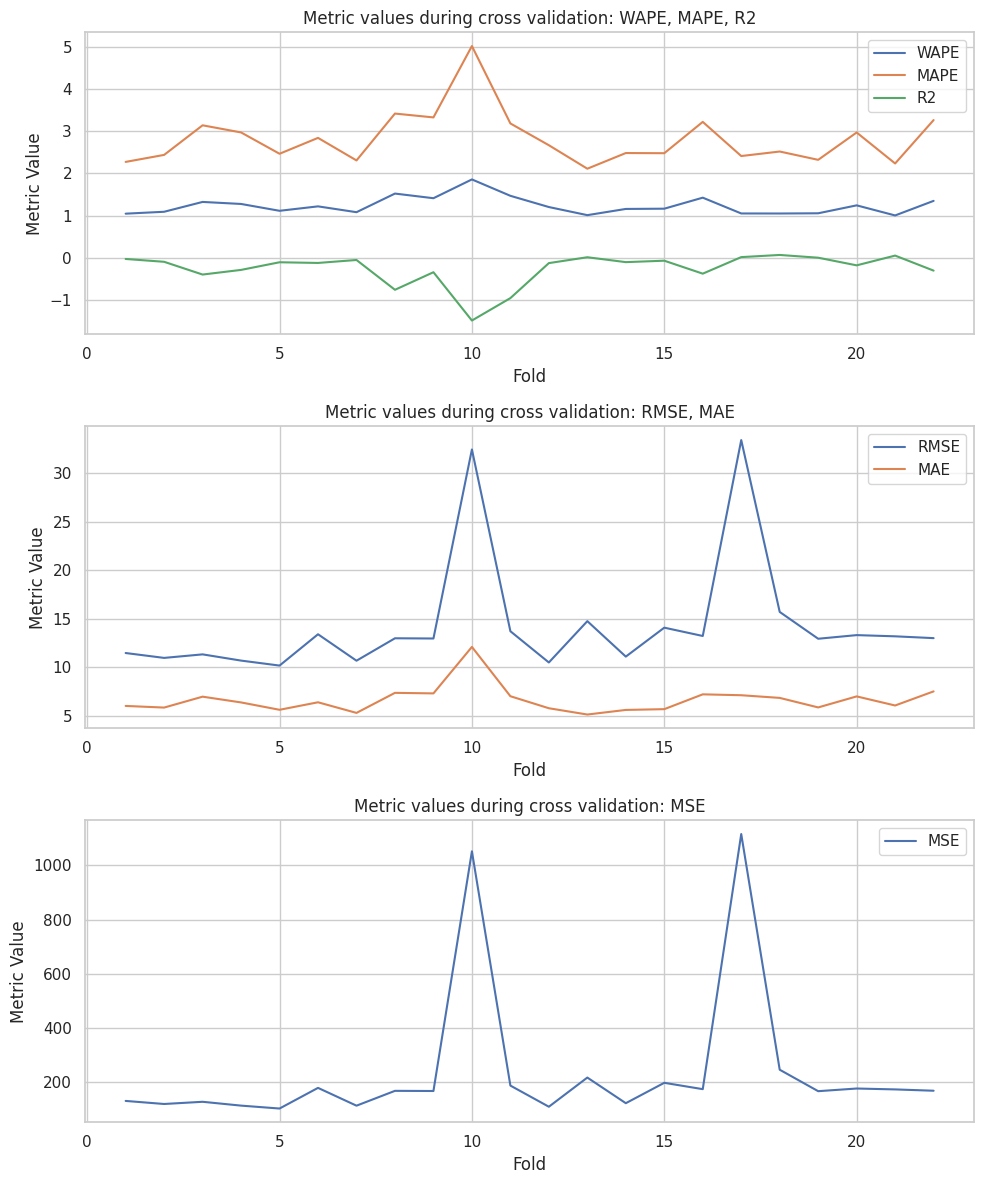

Средние значения метрик по кросс-валидации:


{'wape': 1.234,
 'mape': 2.821,
 'rmse': 14.377,
 'mae': 6.67,
 'mse': 243.111,
 'r2': -0.254}

In [16]:
rf_params = {'n_estimators': 100,
             'criterion': 'squared_error',
             'max_depth': None,
             'bootstrap': True,
             'random_state': RANDOM_STATE,
             'n_jobs': -1}
rf_metrics, rf_pipeline = DatasetExplorer.model_fitting(model_name='Random Forest',
                                                        train_features=X_train.drop(['pr_sku_id'], axis=1),
                                                        train_labels=y_train,
                                                        assets_dir=ASSETS_DIR,
                                                        tscv=tscv,
                                                        params=rf_params,
                                                        params_selection=False)

In [23]:
metadata = {"data_used": "df_new_feat",
            "library_versions": {"mlflow": "2.12.2",
                                 "category-encoders": "2.6.3",
                                 "scikit-learn": "1.4.2"}
           }
code_paths = ['demand_forecast.ipynb', 'regression_research_class.py']
DatasetExplorer.model_logging(experiment_name=EXPERIMENT_NAME,
				   	          run_name='rf_0_registry',
					          registry_model='rf_base',
					          params=rf_pipeline.named_steps['model'].get_params(),
					          metrics=rf_metrics,
					          model=rf_pipeline.named_steps['model'],
					          train_data=X_train,
                              train_label=y_train,
					          assets_dir=ASSETS_DIR,
					          metadata=metadata,
					          code_paths=code_paths,
					          tsh=TRACKING_SERVER_HOST,
					          tsp=TRACKING_SERVER_PORT)

2024/06/25 18:00:35 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.14.1, required: mlflow==2.12.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
Successfully registered model 'rf_base'.
2024/06/25 18:00:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: rf_base, version 1
Created version '1' of model 'rf_base'.


Models and their metrics:


,experiment_name,run_name,model_name,model_version,wape,mape,rmse,mae,mse,r2
0,lenta_demand_forecast,linreg_cv_0_registry,linreg_cv,1,0.874,1.664,12.801,4.727,191.186,0.031
1,lenta_demand_forecast,lgbm_0_registry,lgbm_base,1,0.879,1.699,12.634,4.763,187.008,0.058
2,lenta_demand_forecast,baseline_0_registry,baseline,1,0.891,1.811,12.548,5.117,157.442,0.045
3,lenta_demand_forecast,baseline_cv_registry,baseline_cv,1,0.893,1.778,12.801,4.832,191.194,0.031
4,lenta_demand_forecast,rf_0_registry,rf_base,1,1.234,2.821,14.377,6.670,243.111,-0.254


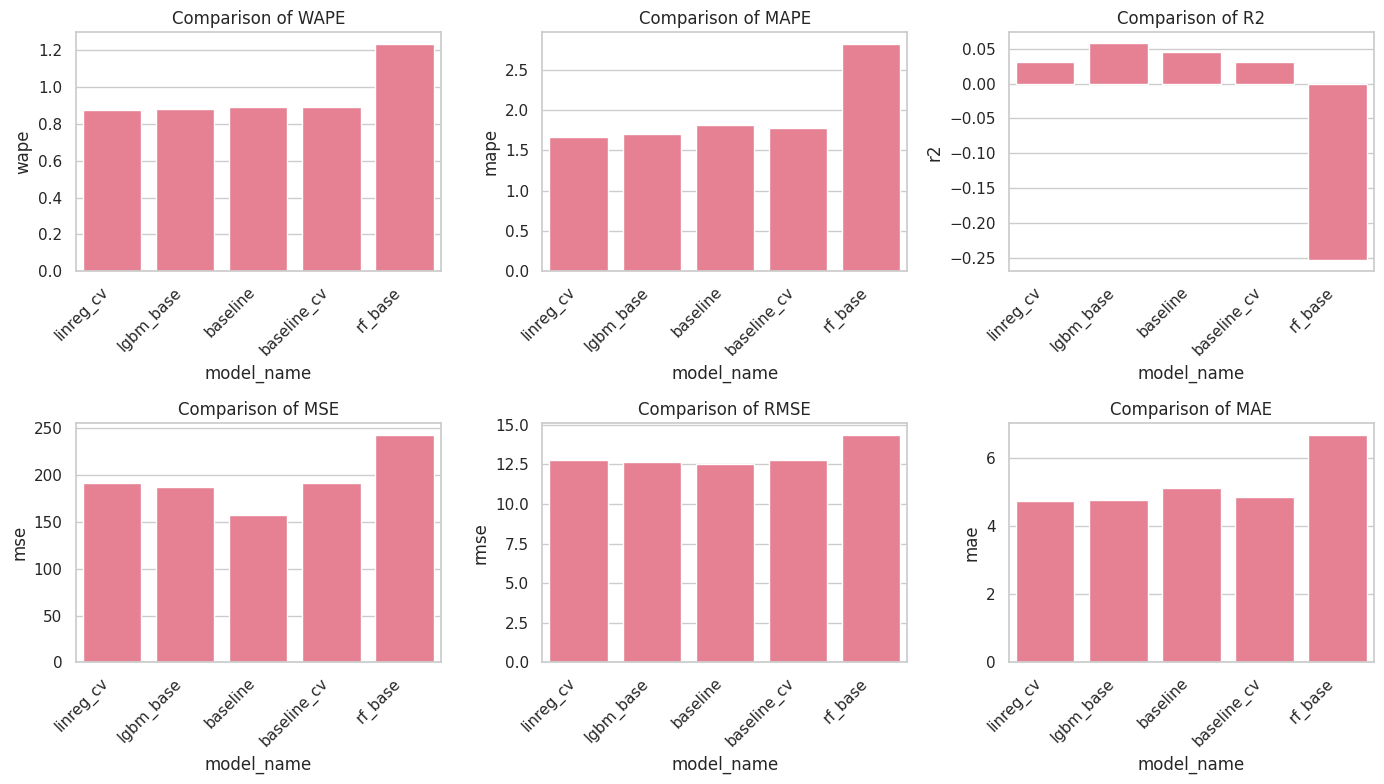

In [24]:
DatasetExplorer.models_comparison(connection=connection,
                                  postgres_credentials=postgres_credentials,
                                  experiment_name=EXPERIMENT_NAME,
                                  assets_dir=None)

Выводы и наблюдения:

- модель  случайного леса, обученная на наборе данных с гиперпараметрами по умолчанию,
  <br>делает предсказания, превышающие истинные значения, что неприемлемо для Заказчика

## LightGBM with Randomized Search

### Modeling

#### Модель `CatBoostRegressor`

In [ ]:
params_cb = (
    {'depth':[7], #[1, 3], [3, 5], [5, 7]
     'l2_leaf_reg': [5], #[1, 3], [3, 5], [5, 7]
     'learning_rate': [0.03], #(0.1, 0.2), (0.05, 0.1), np.arange(0.03, 0.05)
     'iterations': [700]} #n_estimators[100, 300], [300, 500], [500, 700]
    )
model_cbr = CatBoostRegressor(params_cb, random_state=RS, verbose=100)
# model_cbr = CatBoostRegressor(depth=7, l2_leaf_reg=2, learning_rate=0.01, iterations=1000, random_state=RS, verbose=100)

# model_cbr.fit(X_train, y_train, cat_features=cat_features)
# cbc_gs = model_cbc.grid_search(params_cb, Pool(X_train, y_train, cat_features=cat_features), cv=tscv, verbose=100)
# display('Лучшие параметры:', model_cbc.get_params())

cbc_gs = GridSearchCV(model_cbr, params_cb, n_jobs=-1, scoring=make_scorer(wape, greater_is_better=False), cv=tscv)
cbc_gs.fit(X_train, y_train, cat_features=cat_features)
display('Параметры лучшей модели', cbc_gs.best_params_)
display('Показатель wape лучшей модели', cbc_gs.best_score_*(-1)) #0.68, 0.676

0:	learn: 16.0810690	total: 1.05s	remaining: 12m 14s
100:	learn: 12.0891907	total: 41.5s	remaining: 4m 5s
200:	learn: 11.4770135	total: 1m 18s	remaining: 3m 15s
300:	learn: 11.0207913	total: 1m 58s	remaining: 2m 36s
400:	learn: 10.6974900	total: 2m 37s	remaining: 1m 57s
500:	learn: 10.4889966	total: 3m 17s	remaining: 1m 18s
600:	learn: 10.3078562	total: 4m 1s	remaining: 39.8s
699:	learn: 10.1713723	total: 4m 40s	remaining: 0us


'Параметры лучшей модели'

{'depth': 7, 'iterations': 700, 'l2_leaf_reg': 5, 'learning_rate': 0.03}

'Показатель wape лучшей модели'

0.5103740933775973

#### Проверка по метрике качества на тестовых данных

In [ ]:
'Показатель wape лучшей модели на тестовой выборке', wape(y_test, model_cbr.predict(X_test)) #wape(y_test, cbc_gs.predict(X_test)

('Показатель wape лучшей модели на тестовой выборке', 0.48316615497259535)

Диаграмма сравнения предсказаний с реальными данными

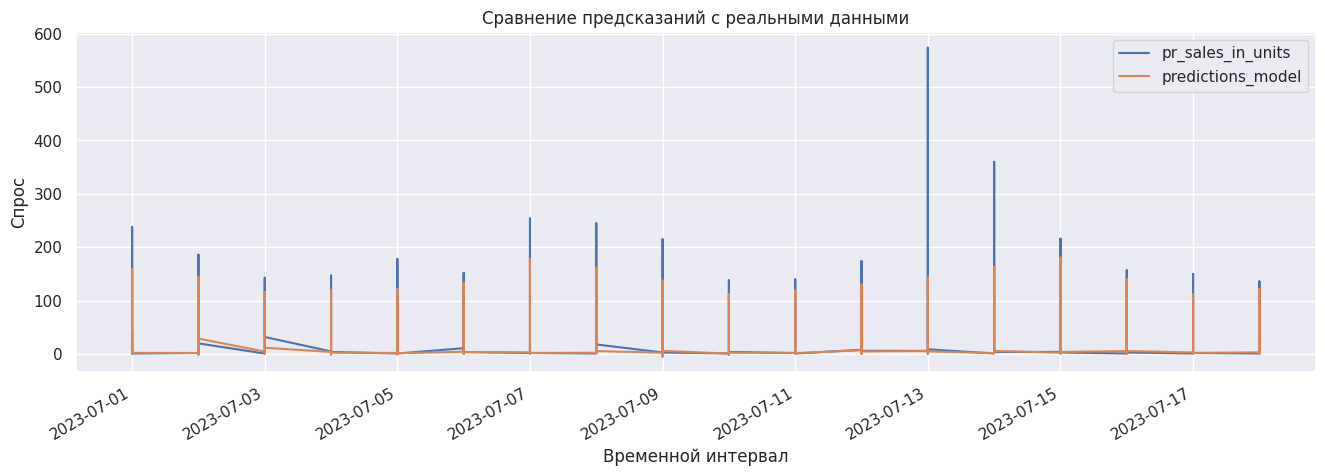

In [ ]:
predictions_model = pd.Series(data = cbc_gs.predict(X_test), name = 'predictions_model', index = X_test.index)

y_test['2023-07-01':'2023-07-31'].plot(figsize=(16,5), grid=True, legend=True)
predictions_model['2023-07-01':'2023-07-31'].plot(grid=True, legend=True)
plt.title('Сравнение предсказаний с реальными данными')
plt.xlabel('Временной интервал')
plt.ylabel('Спрос')
#plt.kind(barplot)
plt.show()

#### Feature importance

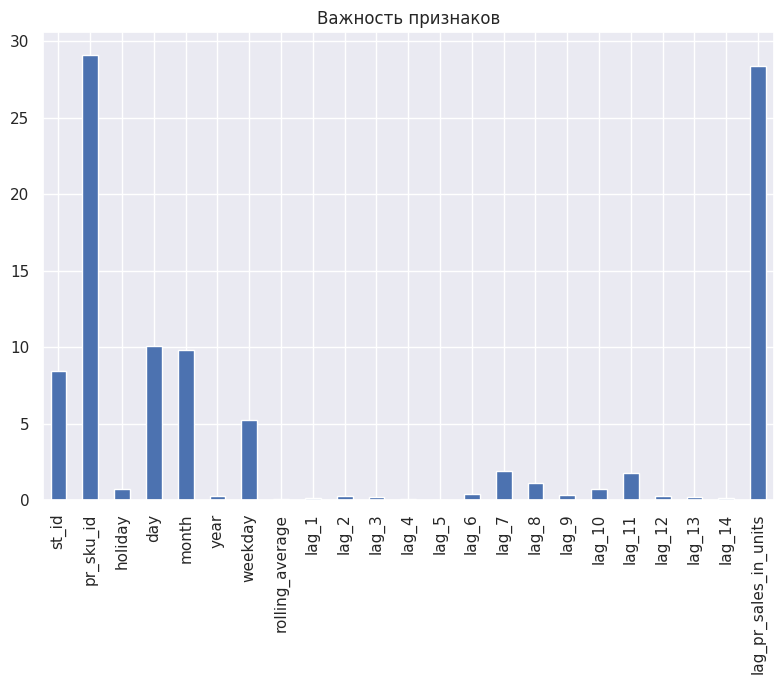

In [ ]:
cbr_fi = pd.Series(cbc_gs.best_estimator_.feature_importances_, X.columns)
fig, ax = plt.subplots(figsize=(8,7))
cbr_fi.plot.bar(ax=ax)
ax.set_title("Важность признаков")
fig.tight_layout()

#### Получение предсказания на следующие две недели

Обучение модели с выбранными параметрами на полном датасете

In [74]:
model_cbr = CatBoostRegressor(depth=7, l2_leaf_reg=5, learning_rate=0.03, n_estimators=700, random_state=RS, verbose=100)
model_cbr.fit(X, y, cat_features=cat_features)

0:	learn: 15.6825277	total: 634ms	remaining: 7m 23s
100:	learn: 12.2570184	total: 42.5s	remaining: 4m 11s
200:	learn: 11.6273114	total: 1m 23s	remaining: 3m 28s
300:	learn: 11.1906155	total: 2m 1s	remaining: 2m 41s
400:	learn: 10.8305776	total: 2m 44s	remaining: 2m 2s
500:	learn: 10.5692663	total: 3m 25s	remaining: 1m 21s
600:	learn: 10.3707171	total: 4m 13s	remaining: 41.7s
699:	learn: 10.2195330	total: 4m 52s	remaining: 0us


Открытие файла, установка даты индексом

In [75]:
sales_submission_s = data.loc[(data['date'] > total_s['date'].max())]
sales_submission_s = sales_submission_s.drop(['pr_sales_in_units'], axis=1)
sales_submission_s = sales_submission_s.set_index('date')
sales_submission_s.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43694 entries, 2023-07-19 to 2023-08-01
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   st_id                  43694 non-null  object 
 1   pr_sku_id              43694 non-null  object 
 2   holiday                43694 non-null  int64  
 3   day                    43694 non-null  int64  
 4   month                  43694 non-null  int64  
 5   year                   43694 non-null  int64  
 6   weekday                43694 non-null  int64  
 7   rolling_average        43694 non-null  float64
 8   lag_1                  43694 non-null  float64
 9   lag_2                  43694 non-null  float64
 10  lag_3                  43694 non-null  float64
 11  lag_4                  43694 non-null  float64
 12  lag_5                  43694 non-null  float64
 13  lag_6                  43694 non-null  float64
 14  lag_7                  43694 non-null

Добавление предсказаний в таблицу, удаление ненужных признаков

In [77]:
sales_submission_s['target'] = model_cbr.predict(sales_submission_s)
sales_submission_s['target'] = round(sales_submission_s['target'], 0)
sales_submission_s = sales_submission_s.reset_index()
sales_submission_s = sales_submission_s.drop(['holiday', 'day', 'month', 'year', 'weekday'], axis=1)
sales_submission_s = sales_submission_s[['st_id', 'pr_sku_id', 'date', 'target']]
sales_submission_s.head()

,st_id,pr_sku_id,date,target
0,6364d3f0f495b6ab9dcf8d3b5c6e0b01,72740338e91de3ccc276b9bc7681bd0d,2023-07-19,1.0
1,6364d3f0f495b6ab9dcf8d3b5c6e0b01,e6449990bb6a761a964e58dd95f7a479,2023-07-19,2.0
2,42a0e188f5033bc65bf8d78622277c4e,4ba72d594b35e41cb3e066397eecdfba,2023-07-19,3.0
3,fa7cdfad1a5aaf8370ebeda47a1ff1c3,3bb2524fb92c7c5fec7a4223e4fadf68,2023-07-19,1.0
4,c81e728d9d4c2f636f067f89cc14862c,b43e19936412e99b8efd1f9061d3f3c7,2023-07-19,5.0


#### Сохранение результатов

Сохранение результата предсказания

In [78]:
sales_submission_s.to_csv('sales_submission_pred.csv', encoding='utf-8')

Запись модели в файл

In [79]:
with open('model_cbr.pkl', 'wb') as f:
  pickle.dump(model_cbr, f)

### Заключение

- Предоставленные данные объединены в единый датафрейм, к ним присоединена информация о праздничных и выходных днях в РФ
- Проведено исследование на корреляцию в признаках, удалены зависимые признаки
- Проведено исследование на сезонность и тренд
- Добавлены синтетические признаки (лаги, даты, скользящее среднее)
- Возникли проблемы при попытке применения техник кодирования, в связи с чем из исследования исключены простые модели ML: линейная регрессия, случайный лес, дерево решений
- Для запуска `ARIMA` недостаточно ресурсов
- Для прогнозирования применена модель градиентного бустинга, т.к. она может одинаково хорошо работает с категориальными и количественными признаками
- При помощи `GridSearch` подобраны оптимальные параметры модели с показателем `wape` на трейне 0.51
- На тестовой выборке показатель `wape` получен 0.48
- Анализ значимости признаков показал, что наиболее важный признак - `lag_pr_sales_in_units` и `pr_sku_id`
- Конечная модель обучена на полном наборе данных